# Aim 3: Characterizing  CD5RA as a Potential Primiitive T-Cell Lineage Marker 

In this final notebook, we will be analyzing Days 7-13 HSCs that were differentiated in LEM according to FW's populations. We will specifically be working on characterizing CD45RA as a potential marker for T-lineage priming, contrasting it's performance with that of CD7. As such, the Research Questions (RQ) for this notebook would be: 

1. How Do CD45RA and CD7 Expression Patterns Interact Over Time, and When Does the CD45RA⁺CD7⁺ State First Emerge?

2. What Transcription Factors and Pathways Are Upregulated in CD45RA+7+ Compared to CD45RA+7- Cells?

3. Do CD45RA⁺7+ Cells Show Higher T-Lineage Gene Module Scores Than Just CD7+ Cells? Does the Acquisition of CLEC12A Affect This? 

4. What Are the Transcriptional Profiles and Phenotypes of CD45RA⁺CD7⁺ Subclusters With Elevated T-Lineage Scores (if any)? 

5. Where Are the CD45RA⁺CD7⁺ High T-Lineage Scoring Clusters Positioned in Pseudotime Relative to Other States? 

Let's begin with Pre-Processing the Data first below: 

## Pre-Processing Workflow 

Let's begin by loading the .RData objects into our environment, and naming all the relevant populations: 

In [53]:
# Loading the necessary libraries

library(BiocSingular) # We need this to use the BioConductor libraries that work on the Single Cell data. #nolint
library(SingleCellExperiment) # We need this to use the SingleCellExperiment data structure.  # nolint
library(ggplot2) # we need this to make ggplot visualizations #nolint
library(tidyr) # we need this to manipulate data #nolint
library(dplyr) # we need this to manipulate data #nolint
library(patchwork) # to display plots side by side. #nolint
library(ggforce) # Allows me to display circles on ggplots. #nolint
library(limma) # helps with differential expression analysis #nolint
library(IRdisplay) # lets me display JPEGs in the notebook #nolint
library(org.Hs.eg.db) # lets me do gene annotation #nolint
library(clusterProfiler) # lets me do gene set enrichment analysis #nolint
library(broom) # lets me manipulate data #nolint
library(enrichplot) # lets me visualize gene set enrichment analysis #nolint
library(scales) # for percent_format()
library(tidyverse) # lets me manipulate data #nolint
library(ggrepel) # for non-overlapping labels
library(pheatmap) # for heatmaps #nolint
library(scran)
library(igraph)


Loading required package: scuttle


Attaching package: 'igraph'


The following objects are masked from 'package:lubridate':

    %--%, union


The following objects are masked from 'package:purrr':

    compose, simplify


The following object is masked from 'package:tibble':

    as_data_frame


The following object is masked from 'package:clusterProfiler':

    simplify


The following objects are masked from 'package:dplyr':

    as_data_frame, groups, union


The following object is masked from 'package:tidyr':

    crossing


The following object is masked from 'package:GenomicRanges':

    union


The following object is masked from 'package:IRanges':

    union


The following object is masked from 'package:S4Vectors':

    union


The following objects are masked from 'package:BiocGenerics':

    normalize, path, union


The following objects are masked from 'package:stats':

    decompose, spectrum


The following object is masked from 'package:base':

    union




In [2]:
load("data/phenotype_with_ID.RData")
load("data/merge2.RData")

# Adding Phenotype data to the SCE object
pheno.d7 <- rep("CD34+CD45RA-CLEC12A-", 3039)
names(pheno.d7) <- colnames(merge2)[1:3039]

pheno.merge2 <- c(pheno.d7, pheno.d10, pheno.d13)


colData(merge2)$Phenotype <- pheno.merge2


# Cleaning Up the Phenotype Data so it belongs to the 3 populations

# Define phenotype groups
phenotype_groups <- list(
    Cneg = c("CD34+CD45RA-CLEC12A-", "CD34-CD45RA-CLEC12A-", "CD34+CD45RA+CLEC12A-", "CD34-CD45RA+CLEC12A-"), # Ra-C-
    Cpos = c("CD34-CD45RA-CLEC12A+", "CD34+CD45RA-CLEC12A+", "CD34+CD45RA+CLEC12A+", "CD34-CD45RA+CLEC12A+"), # C+ # nolint
    Other = c("CD10+", "CD14CD15+") # Pro -B #Pro-NM #FW Gating from a flow cytometer #nolint
)

# Assign group labels to phenotypes
group_labels <- sapply(pheno.merge2, function(phenotype) {
    group <- names(phenotype_groups)[sapply(phenotype_groups, function(g) phenotype %in% g)] # nolint
    if (length(group) > 0) group else "Other"
})

# Add group labels to colData of the SCE object
colData(merge2)$Group <- group_labels


Great! Now let's add a table labelling which day each table belongs to: 

In [3]:
# Extract the day information from cell names
colData(merge2)$Day <- gsub(".*Day_([0-9]+).*", "\\1", rownames(colData(merge2)))
# Convert to a factor (optional, for better categorical handling)
colData(merge2)$Day <- factor(colData(merge2)$Day, levels = sort(unique(colData(merge2)$Day)))


# Define columns to keep
cols_to_keep <- c("Group", "Day", "Phenotype")

# Create a lighter version of the SCE object
merge2_light <- merge2
colData(merge2_light) <- colData(merge2_light)[, cols_to_keep]

# Checking characteristics of the new light version
merge2_light
colnames(colData(merge2_light))


class: SingleCellExperiment 
dim: 36601 12181 
metadata(12): Samples scDblFinder.stats ... scDblFinder.stats
  scDblFinder.threshold
assays(2): counts logcounts
rownames(36601): MIR1302-2HG FAM138A ... AC007325.4 AC007325.2
rowData names(3): ID Symbol Type
colnames(12181): cell1Day_7 cell2Day_7 ... cell5137Day_13
  cell5138Day_13
colData names(3): Group Day Phenotype
reducedDimNames(9): PCA.cc UMAP.cc ... PCA TSNE
mainExpName: Gene Expression
altExpNames(1): Antibody Capture

[1] "Group"     "Day"       "Phenotype"

Great! Let's now create a gate for CD7 based on gene expression: 

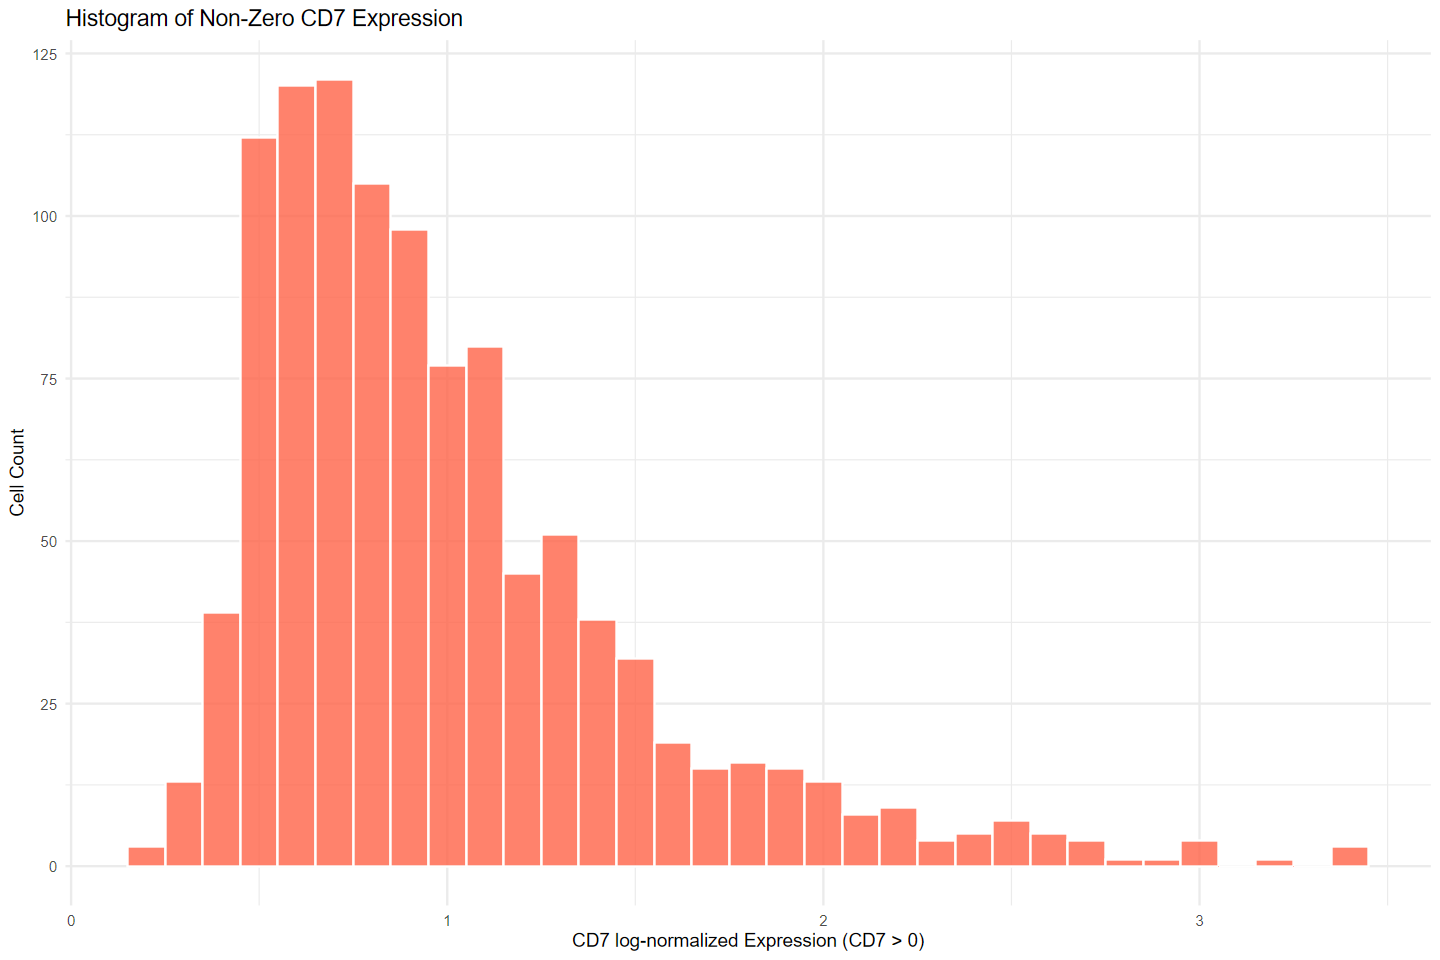

In [4]:
# Creating a Violin Plot to Generate CD7 Distribution Across All Cells Overall

options(repr.plot.width = 12, repr.plot.height = 8)

# 1. Extract CD7 expression from the RNA assay
cd7_expr <- logcounts(merge2_light)["CD7", ]


# 2. Add CD7 expression to metadata
colData(merge2_light)$CD7_gene <- cd7_expr

# Filter to cells with CD7_expr > 0
# becuase otherwise the plot becomes right skewed and useless
nonzero_df <- as.data.frame(colData(merge2_light)) %>%
  filter(CD7_gene > 0)

# Plot histogram of non-zero CD7 expression
ggplot(nonzero_df, aes(x = CD7_gene)) +
  geom_histogram(binwidth = 0.1, fill = "tomato", color = "white", alpha = 0.8) +
  labs(
    title = "Histogram of Non-Zero CD7 Expression",
    x = "CD7 log-normalized Expression (CD7 > 0)",
    y = "Cell Count"
  ) +
  theme_minimal()


colData(merge2_light)$CD7_geneStat <- case_when(
  merge2_light$CD7_gene == 0 ~ "CD7_0",
  merge2_light$CD7_gene >= 1 ~ "CD7_hi",
  TRUE ~ "CD7_lo" # Optional middle category
)


Great! Based on the visualization, this is the gating strategy I implemented: 

CD7 Status | Expression Range (CD7_expr)	| Rationale|
-----------|--------------------------------|----------|
CD7_0	|≤ 0	|Truly negative|
CD7-lo	|> 0 & < 1	|Weak expression; transitional or noise|
CD7-hi	|≥ 1	|Stronger, confident expression|


Now let's work on gating the same, using the ADT assay:  

[1] "Group"        "Day"          "Phenotype"    "CD7_gene"     "CD7_geneStat"
[6] "CD7_adt"      "CD7_adtStat"

        CD7_adt
CD7_gene FALSE  TRUE
   FALSE 11117     0
   TRUE     24  1040

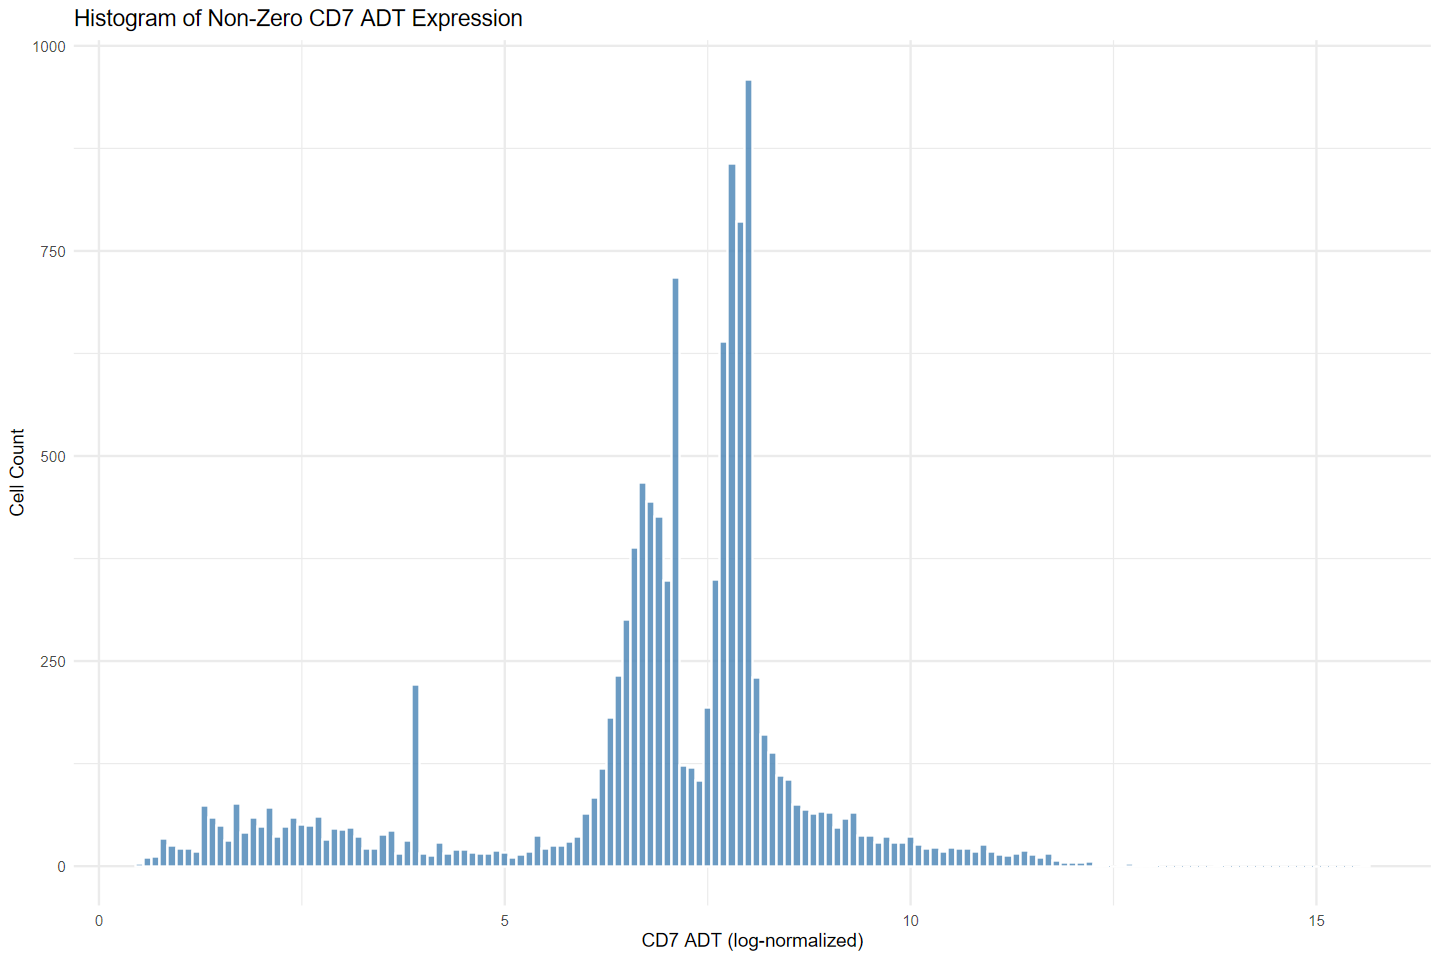

In [5]:
# Extract CD7 ADT signal from Antibody Capture assay
cd7_adt <- logcounts(altExp(merge2_light, "Antibody Capture"))["TOTALSEQB_CD7", ]
colData(merge2_light)$CD7_adt <- cd7_adt

# Filter to non-zero ADT values to avoid heavy skew
adt_nonzero <- as.data.frame(colData(merge2_light)) %>%
    filter(CD7_adt > 0)

# Plot histogram
ggplot(adt_nonzero, aes(x = CD7_adt)) +
    geom_histogram(binwidth = 0.1, fill = "steelblue", color = "white", alpha = 0.8) +
    labs(
        title = "Histogram of Non-Zero CD7 ADT Expression",
        x = "CD7 ADT (log-normalized)",
        y = "Cell Count"
    ) +
    theme_minimal()

colData(merge2_light)$CD7_adtStat <- case_when(
    merge2_light$CD7_adt <= 1 ~ "CD7-",
    merge2_light$CD7_adt >= 6 ~ "CD7+",
    TRUE ~ "CD7~"
)

colnames(colData(merge2_light))

# Identify which cells have CD7_gene == 0
zero_gene_idx <- which(colData(merge2_light)$CD7_gene == 0)

# Set their ADT expression to 0
colData(merge2_light)$CD7_adt[zero_gene_idx] <- 0

# Set their ADT status to "CD7-"
colData(merge2_light)$CD7_adtStat[zero_gene_idx] <- "CD7-"

# Check the updated data frame
table(CD7_gene = merge2_light$CD7_gene > 0, CD7_adt = merge2_light$CD7_adt > 0)


Cool! The gating strategy I used for this (reminder, all this is just a repeat of the process in Aim 2) is shown below: 

**Gating Strategy for CD7 ADT**:

| Gate        | Range (CD7_adt) | Rationale                           |
|-------------|------------------|-------------------------------------|
| **CD7-**   | `≤ 1`            | Undetectable expression (log-space 0) |
| **CD7~**  | `> 1 & < 6`      | Ambiguous or transitional zone     |
| **CD7+**  | `≥ 6`            | Robust protein-level CD7 expression |

I have also already fixed the stickyness issue in the code above. 

Now, let's repeat this process with CD45RA. Note that CD45RA  is an isoform of CD45, which is a protein coded by the `PTPRC` gene, which is commong for all isoforms. So I **can not simply gate based on gene expression**, since the gene is not specific to 45RA at all, and this would make any of the results I find worthless. 

As such, I will be establishing a work-around by gating based on ADT only, and forcing cells with 0 PTPRC expression to be CD45RA-, and then applying some statistical filters to gate out some more of the non-specific binding. Note however, this would still be a major hit to the statistical rigour of these findings. 

Let's code this in below: 

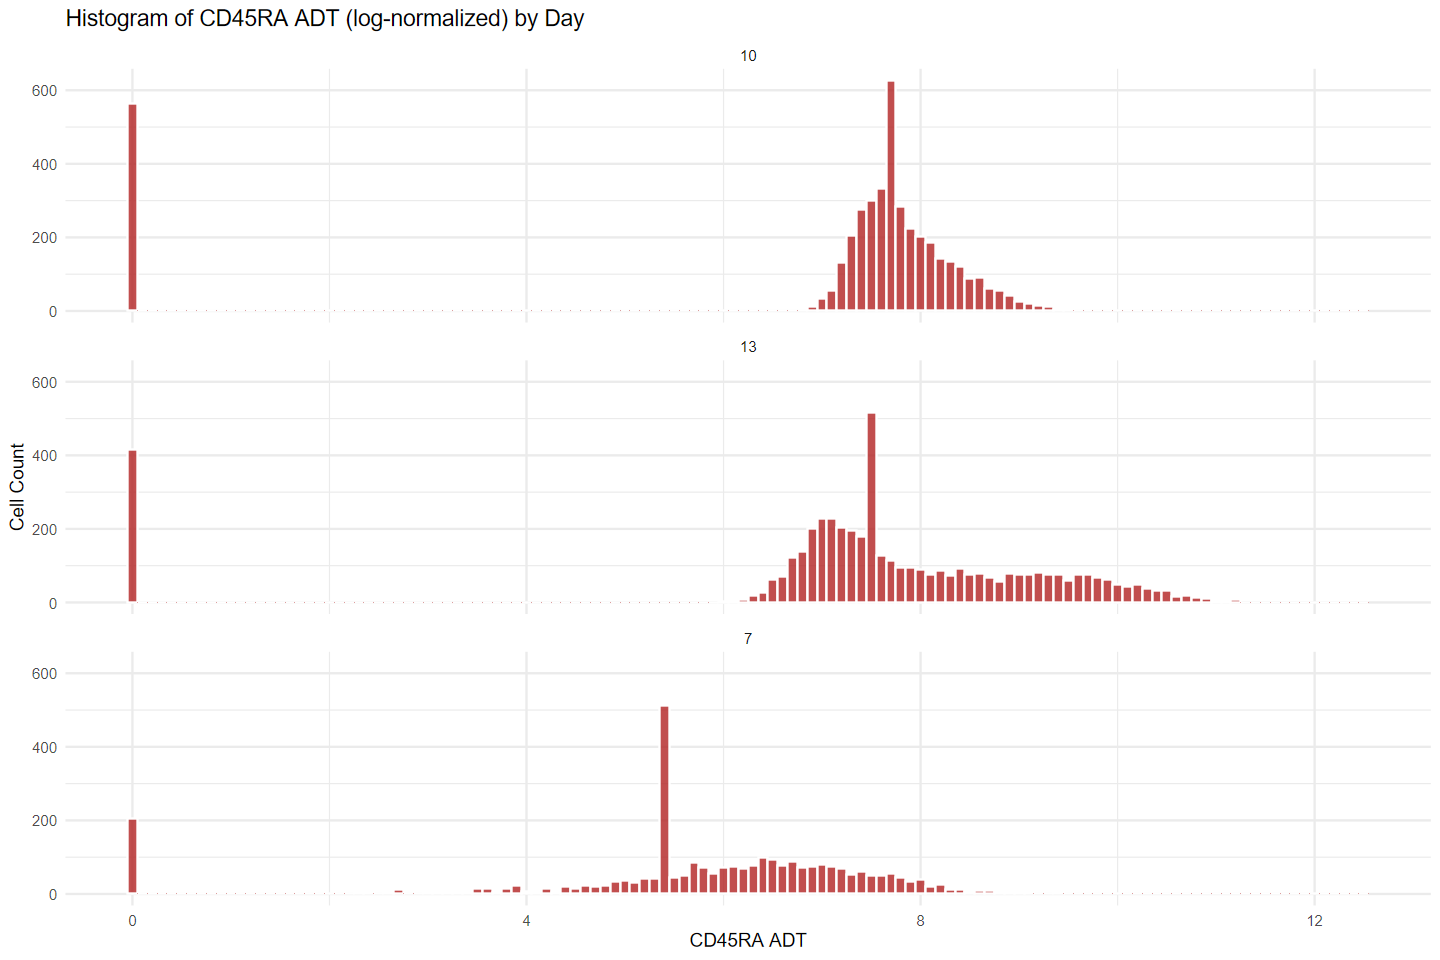

In [6]:
# Step 1: Extract CD45RA ADT values
cd45ra_adt <- logcounts(altExp(merge2_light, "Antibody Capture"))["TOTALSEQB_CD45RA", ]
colData(merge2_light)$CD45RA_adt <- cd45ra_adt

# Step 2: Filter out non-hematopoietic cells using PTPRC
ptprc_expr <- logcounts(merge2_light)["PTPRC", ]
ptprc_cutoff <- 0.25
ptprc_positive <- ptprc_expr > ptprc_cutoff

# Optional: Set CD45RA ADT to 0 for PTPRC- cells, and track them
colData(merge2_light)$CD45RA_adt[!ptprc_positive] <- 0
colData(merge2_light)$CD45RA_stat <- ifelse(!ptprc_positive, "CD45RA-", NA)

# Step 3: Visualize CD45RA ADT by Day (post-filtering)
library(ggplot2)
cd45ra_df <- as.data.frame(colData(merge2_light)) %>%
  filter(!is.na(CD45RA_adt))

ggplot(cd45ra_df, aes(x = CD45RA_adt)) +
  geom_histogram(binwidth = 0.1, fill = "firebrick", color = "white", alpha = 0.8) +
  facet_wrap(~Day, scales = "fixed", ncol = 1) +
  labs(
    title = "Histogram of CD45RA ADT (log-normalized) by Day",
    x = "CD45RA ADT", y = "Cell Count"
  ) +
  theme_minimal()


Here’s how I would interpret these results:

- **Very sharp peak at 0**: likely true CD45RA⁻ cells and/or background noise.
- **Clear separation** begins around log-normalized ADT ≈ 2.5–3.
- **Robust, unimodal peak** around 7.5: strong CD45RA⁺ signal.
- A spike near ~5 is likely technical (common in CITE-seq) — potentially aggregates or residual antibody binding.

Here's the gating thresholds I will be implementing: 

| Gate        | CD45RA ADT Range        | Rationale                                        |
|-------------|--------------------------|--------------------------------------------------|
| `CD45RA⁻`   | ≤ **2.5**                | No expression / noise                           |
| `CD45RA~`   | > 2.5 & < 6              | Ambiguous or low-level staining                 |
| `CD45RA⁺`   | ≥ **6**                  | Clear, biologically meaningful surface signal   |

In [7]:
# Extract CD45RA ADT and PTPRC expression vectors from colData
cd45ra_adt <- colData(merge2_light)$CD45RA_adt
ptprc_expr <- logcounts(merge2_light)["PTPRC", ]
ptprc_cutoff <- 0.25

# Generate gating status
colData(merge2_light)$CD45RA_stat <- case_when(
  ptprc_expr <= ptprc_cutoff ~ "CD45RA-", # Force CD45RA- for PTPRC- cells
  cd45ra_adt <= 2.5 ~ "CD45RA-",
  cd45ra_adt >= 6 ~ "CD45RA+",
  TRUE ~ "CD45RA~"
)


Let's now do some gating for CD5 based on gene expression: 

In [8]:
"CD3E" %in% rownames(merge2_light)


[1] TRUE

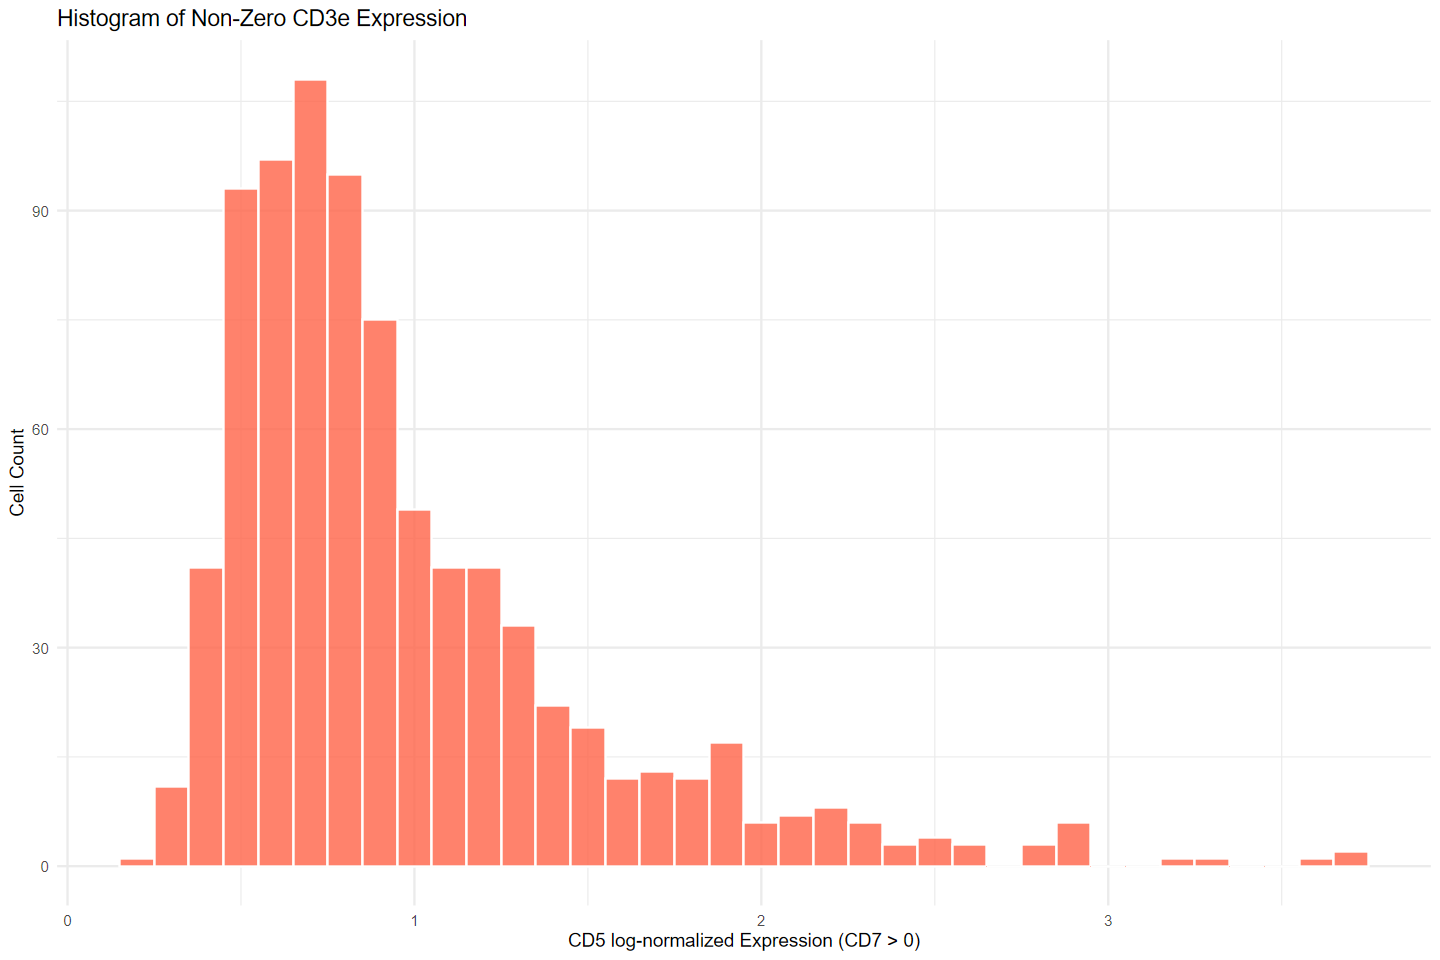

In [ ]:
# Creating a Violin Plot to Generate CD5 Distribution Across All Cells Overall

options(repr.plot.width = 12, repr.plot.height = 8)

# 1. Extract CD5 expression from the RNA assay
cd3e_expr <- logcounts(merge2_light)["CD3E", ]


# 2. Add CD5 expression to metadata
colData(merge2_light)$CD3e_gene <- cd3e_expr

# Filter to cells with CD5_expr > 0
# becuase otherwise the plot becomes right skewed and useless
nonzero_df <- as.data.frame(colData(merge2_light)) %>%
  filter(CD3e_gene > 0)

# Plot histogram of non-zero CD5 expression
ggplot(nonzero_df, aes(x = CD3e_gene)) +
  geom_histogram(binwidth = 0.1, fill = "tomato", color = "white", alpha = 0.8) +
  labs(
    title = "Histogram of Non-Zero CD3e Expression",
    x = "CD5 log-normalized Expression (CD7 > 0)",
    y = "Cell Count"
  ) +
  theme_minimal()


colData(merge2_light)$CD3e_geneStat <- case_when(
  merge2_light$CD3e_gene == 0 ~ "CD3e-",
  merge2_light$CD3e_gene >= 1 ~ "CD3e_hi",
  TRUE ~ "CD3e_lo" # Optional middle category
)


Great! We are now ready to dive into the analysis workflow! 

## Analysis Workflow 

### RQ1: Do CD45RA+CD7- Cells Exist At Earlier Timepoints, and How Does Their Proportion Compare to Earlier Timepoints 



To evaluate whether CD45RA can serve as an early indicator of T-lineage priming, it is important to determine when CD45RA⁺CD7⁻ cells first emerge and how their abundance changes over time. If CD45RA⁺CD7⁻ cells are detectable at earlier timepoints—before robust CD7 expression is established—this would support the hypothesis that CD45RA marks a priming event that precedes or operates independently of CD7. Tracking their proportional dynamics across Days 7–13 enables us to assess whether CD45RA expression anticipates CD7 and thereby holds greater utility as an early marker of T-lineage bias.

Let's begin by visualizing the proportion of all CD45RA+/- & CD7+/- cells over time, from all populations: 

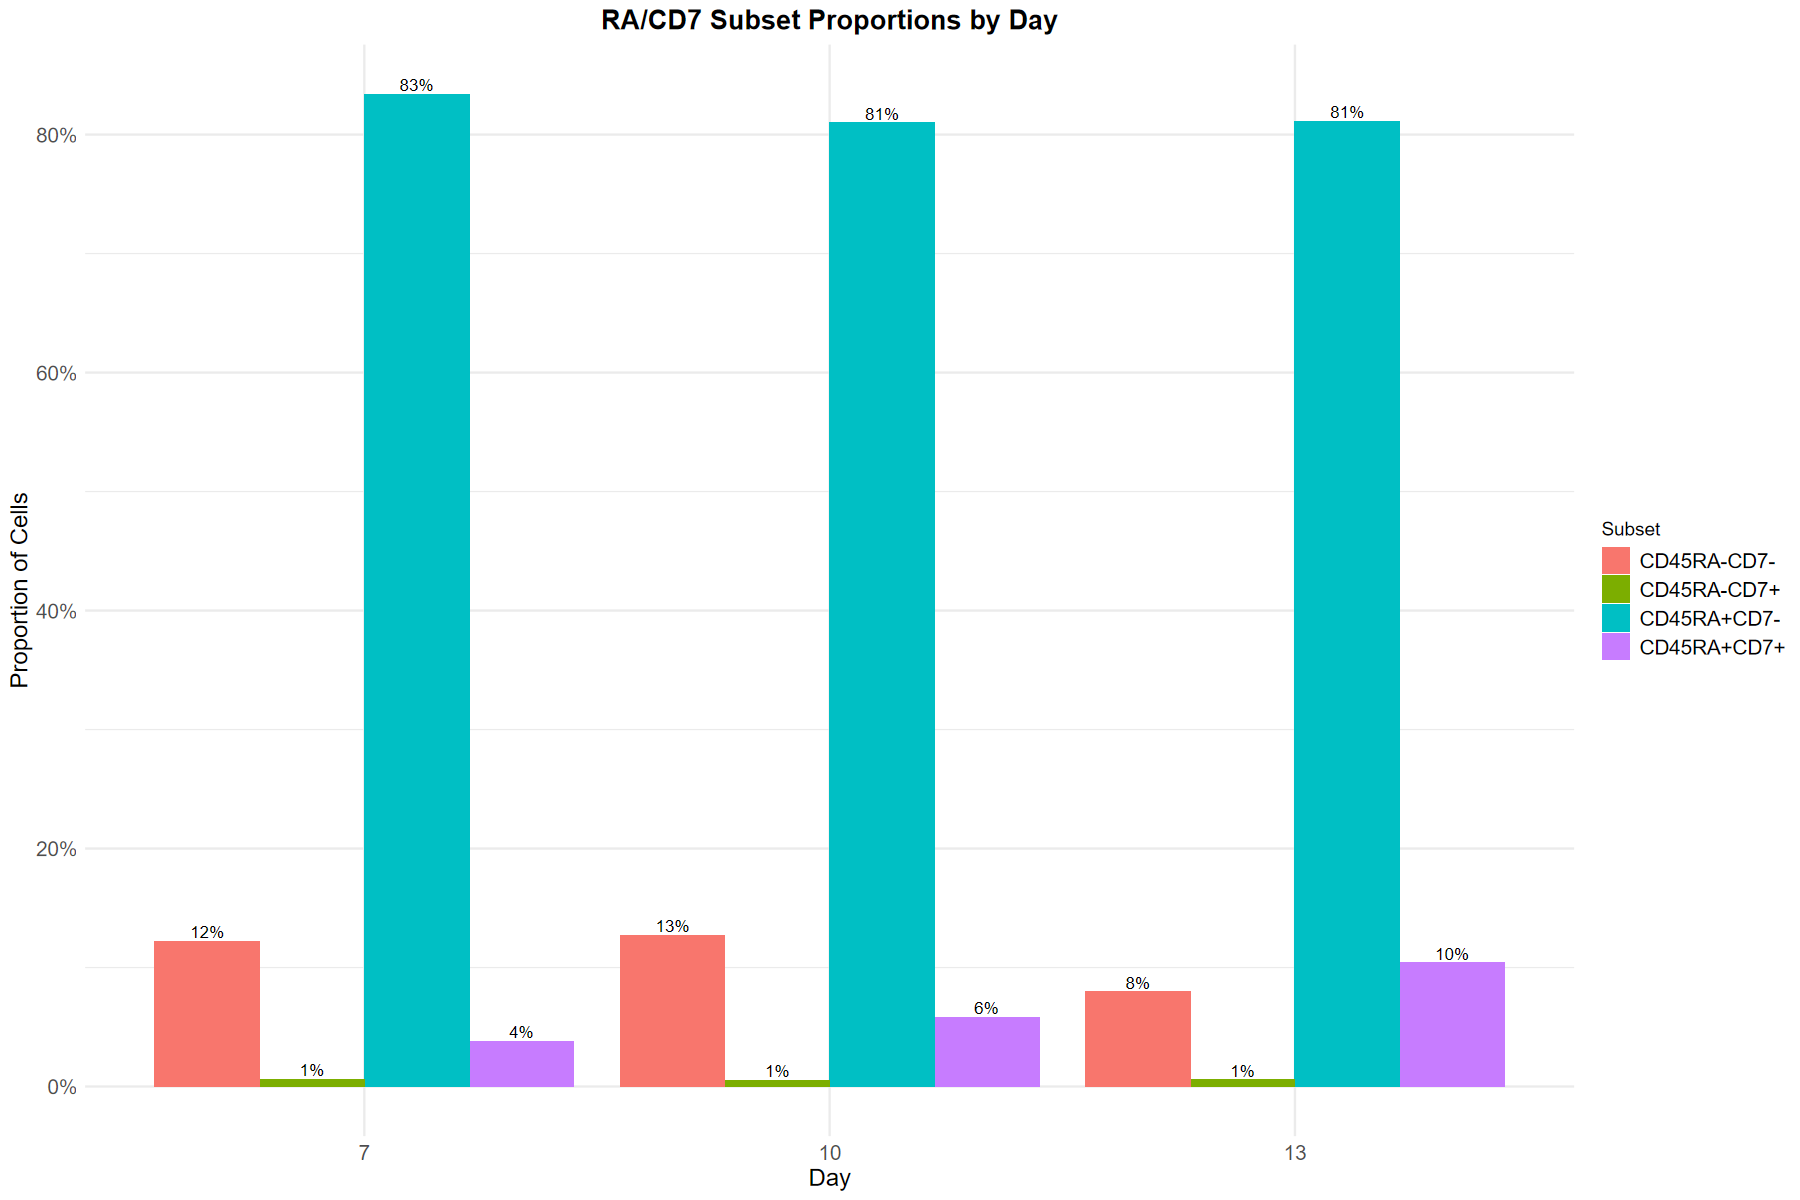

In [10]:
options(repr.plot.width = 15, repr.plot.height = 10)

# Step 1: Extract metadata into a dataframe
meta_df <- as.data.frame(colData(merge2_light))


# Step 1: Define combo categories across all cells
meta_df <- meta_df %>%
  mutate(RA7_combo_full = case_when(
    CD45RA_stat == "CD45RA+" & CD7_adtStat == "CD7+" ~ "CD45RA+CD7+",
    CD45RA_stat == "CD45RA+" & CD7_adtStat == "CD7-" ~ "CD45RA+CD7-",
    CD45RA_stat == "CD45RA-" & CD7_adtStat == "CD7+" ~ "CD45RA-CD7+",
    CD45RA_stat == "CD45RA-" & CD7_adtStat == "CD7-" ~ "CD45RA-CD7-",
    TRUE ~ "Other"
  ))

# Step 2: Count by day and combo
combo_df <- meta_df %>%
  filter(RA7_combo_full != "Other") %>%
  group_by(Day, RA7_combo_full) %>%
  summarise(N = n(), .groups = "drop") %>%
  group_by(Day) %>%
  mutate(Prop = N / sum(N))

# Reorder Day as a factor with levels in desired order
combo_df$Day <- factor(combo_df$Day, levels = c("7", "10", "13"))


# Plot side-by-side bars (position = "dodge") with percentage labels
prop_plot_AllHSCs <- ggplot(combo_df, aes(x = Day, y = Prop, fill = RA7_combo_full)) + # nolint
  geom_col(position = position_dodge(width = 0.9)) +
  geom_text(aes(label = scales::percent(Prop, accuracy = 1)),
    position = position_dodge(width = 0.9),
    vjust = -0.25, size = 3.5
  ) +
  scale_y_continuous(labels = percent_format()) +
  labs(
    title = "RA/CD7 Subset Proportions by Day",
    x = "Day", y = "Proportion of Cells",
    fill = "Subset"
  ) +
  theme_minimal() +
  theme(legend.position = "right") +
  theme(
    plot.title = element_text(hjust = 0.5, size = 16, face = "bold"),
    axis.title = element_text(size = 14),
    axis.text = element_text(size = 12),
    plot.subtitle = element_text(size = 15, face = "italic"),
    strip.text = element_text(size = 12),
    legend.text = element_text(size = 12),
  )

print(prop_plot_AllHSCs)


Here's my interpretation of these results: 


**CD45RA⁺CD7⁻ (Teal: 83% on Day 7, 81% on Days 10/13)**

- Present at very **high** levels from Day 7 onward, indicating that CD45RA expression precedes CD7 during early T-lineage priming.
- Their dominance at the earliest timepoint strongly supports the hypothesis that CD45RA⁺CD7⁻ cells represent an early-primed, lymphoid-biased state — prior to CD7 induction.
    - These cells are not expressing CD7 — a known **pan-T marker** — yet they’re already **expressing CD45RA**, which is often re-expressed on **committed lymphoid progenitors**.
- The relatively **stable frequency** of this population suggests that **CD45RA⁺ priming is initiated early and maintained**, aligning with a gradual or stepwise model of commitment.

**CD45RA⁺CD7⁺ (Purple: 4% on Day 7, increasing to 10% by Day 13)**

- This population emerges gradually over time, consistent with the idea that **CD7 turns on later**, within a **CD45RA⁺-primed background**.
- Suggests progression from CD45RA⁺CD7⁻ → CD45RA⁺CD7⁺, matching models of T-cell specification (e.g., in the Yale paper or Edgar’s pseudotime analysis).
    - This implies that **CD45RA expression is a prerequisite** for T-lineage activation — i.e., **CD7 expression only occurs in CD45RA⁺ cells**.

**CD45RA⁻CD7⁻ (Red: ~12–13% on Day 7/10, decreasing to 8% by Day 13)**

- Likely includes **non-responding or latent HSCs** that remain unprimed for lymphoid-lineage, possibly retained from the Ra⁻C⁻ gate.
- Their **declining proportion over time** reflects selection against unprimed cells under T-inductive conditions (i.e., LEM cytokines).

**CD45RA⁻CD7⁺ (Green: ~1% at all timepoints)**

- Very rare population, likely representing **transient noise**, **technical artifacts**, or cells with **non-hematopoietic CD7 activation**.
- Critically, their frequency **does not increase over time**, and **remains negligible** despite lymphoid-lineage stimulation.

**Biological Model Emerging fromThis**

I'm building towards a model where:

Undifferentiated HSC → CD45RA⁻CD7⁻ (latent/unprimed) -> CD45RA⁺CD7⁻ (primed) → CD45RA⁺CD7⁺ (T-lineage Initial Priming)
               

**Takeaways**: 

Given our Aim 3 hypothesis:
> **CD45RA, particularly in the CD45RA⁺CD7+ state, is a better marker of early T-lineage priming than CD7+ alone.**

- CD45RA expression is **present and dominant by Day 7**, while CD7⁺ cells are scarce.
- CD7⁺ cells emerge **only within the CD45RA⁺ population**, suggesting that **CD45RA marks an upstream primed state**.
- CD45RA⁻CD7⁺ cells are **rare and not expanding**, weakening the case for CD7 as an early standalone marker.
- But by being upstream, CD45RA is also not inspiring confidence in it's role as a more selective T-lineage marker at this stage. 


> In my opinion, this doesn't mean that 45RA+ is a better/worse marker than CD7+ - we haven't tested that yet. Instead, these plots mean that 45RA+ is an earlier (possibly earliest?) detectable marker of Lymphoid/T-lineage commitment, and exploring subsets of CD45RA+ for T-lineage genes would be key to finding a more restricted population. 


### RQ2: What Transcription Factors and Pathways Are Upregulated in CD45RA+7+ Compared to CD45RA+7- Cells?



In this section, we are going to try to characterize the transcriptional differences that occur with the acquisition of CD7 within the CD45 subpopulation. We will do so by completing some 

In [11]:
run_dge_dataframe <- function(expr_matrix, group_vector) {
  stopifnot(length(group_vector) == ncol(expr_matrix))

  # Sanitize group names (e.g., CD7+ → CD7pos, CD7- → CD7neg)
  group_vector_clean <- recode(group_vector, "CD7+" = "CD7pos", "CD7-" = "CD7neg")

  # Create design matrix with clean names
  group_factor <- factor(group_vector_clean, levels = c("CD7neg", "CD7pos"))
  design <- model.matrix(~ 0 + group_factor)
  colnames(design) <- levels(group_factor)

  # Fit model and apply contrast
  fit <- lmFit(expr_matrix, design)
  contrast.matrix <- makeContrasts(CD7pos_vs_CD7neg = CD7pos - CD7neg, levels = design)
  fit2 <- contrasts.fit(fit, contrast.matrix)
  fit2 <- eBayes(fit2)

  # Extract results
  top_genes <- topTable(fit2, coef = 1, number = Inf, sort.by = "logFC")
  cd_genes <- top_genes[grep("^CD\\d+", top_genes$ID), ]

  return(list(top_genes = top_genes, top_cd_genes = cd_genes))
}


In [89]:
# Suppose you’ve already subsetted your data to CD45RA+ cells:
sce_ra_pos <- merge2_light[, merge2_light$CD45RA_stat == "CD45RA+" & merge2_light$CD7_adtStat %in% c("CD7+", "CD7-")]

# Run function
result <- run_dge_dataframe(
  expr_matrix = logcounts(sce_ra_pos),
  group_vector = colData(sce_ra_pos)$CD7_adtStat
)


Warning message in asMethod(object):
"sparse->dense coercion: allocating vector of size 2.6 GiB"
Warning message:
"Zero sample variances detected, have been offset away from zero"


Great! Let's visualize these results using a volcano plot and heatmap: 

In [ ]:
draw_volcano <- function(result) {
  # --- Assume result$top_genes already exists ---
  df <- result$top_genes

  # Define thresholds
  fc_thresh <- 0.5
  pval_thresh <- 0.05

  # Annotate significance
  df <- df %>%
    mutate(
      Significant = case_when(
        adj.P.Val < pval_thresh & logFC > fc_thresh ~ "Up",
        adj.P.Val < pval_thresh & logFC < -fc_thresh ~ "Down",
        TRUE ~ "Not Significant"
      )
    )

  # Get top 10 genes for labeling
  top_labels <- df %>%
    filter(Significant != "Not Significant") %>%
    arrange(adj.P.Val) %>%
    slice_head(n = 10)

  # Make volcano plot
  ggplot(df, aes(x = logFC, y = -log10(adj.P.Val), color = Significant)) +
    # Highlight thresholds
    geom_vline(xintercept = c(-fc_thresh, fc_thresh), linetype = "dashed", color = "gray50") +
    geom_hline(yintercept = -log10(pval_thresh), linetype = "dotted", color = "gray50") +

    # Points
    geom_point(alpha = 0.8, size = 2) +

    # Labels
    geom_text_repel(
      data = top_labels,
      aes(label = ID),
      size = 3.5,
      max.overlaps = 15,
      box.padding = 0.3,
      segment.color = "gray40",
      show.legend = FALSE
    ) +

    # Aesthetics
    scale_color_manual(values = c("Up" = "#d73027", "Down" = "#4575b4", "Not Significant" = "#bababa")) +
    labs(
      title = "Volcano Plot: Differential Expression",
      subtitle = paste0("Dashed = log2FC ±", fc_thresh, ", Dotted = adj.P.Val <", pval_thresh),
      x = "log2 Fold Change",
      y = expression(-log[10]("Adjusted P-Value")),
      color = "Significance"
    ) +
    theme_minimal(base_size = 14) +
    theme(
      plot.title = element_text(face = "bold", size = 16),
      plot.subtitle = element_text(size = 12),
      axis.title = element_text(face = "bold"),
      legend.position = "right"
    )
}


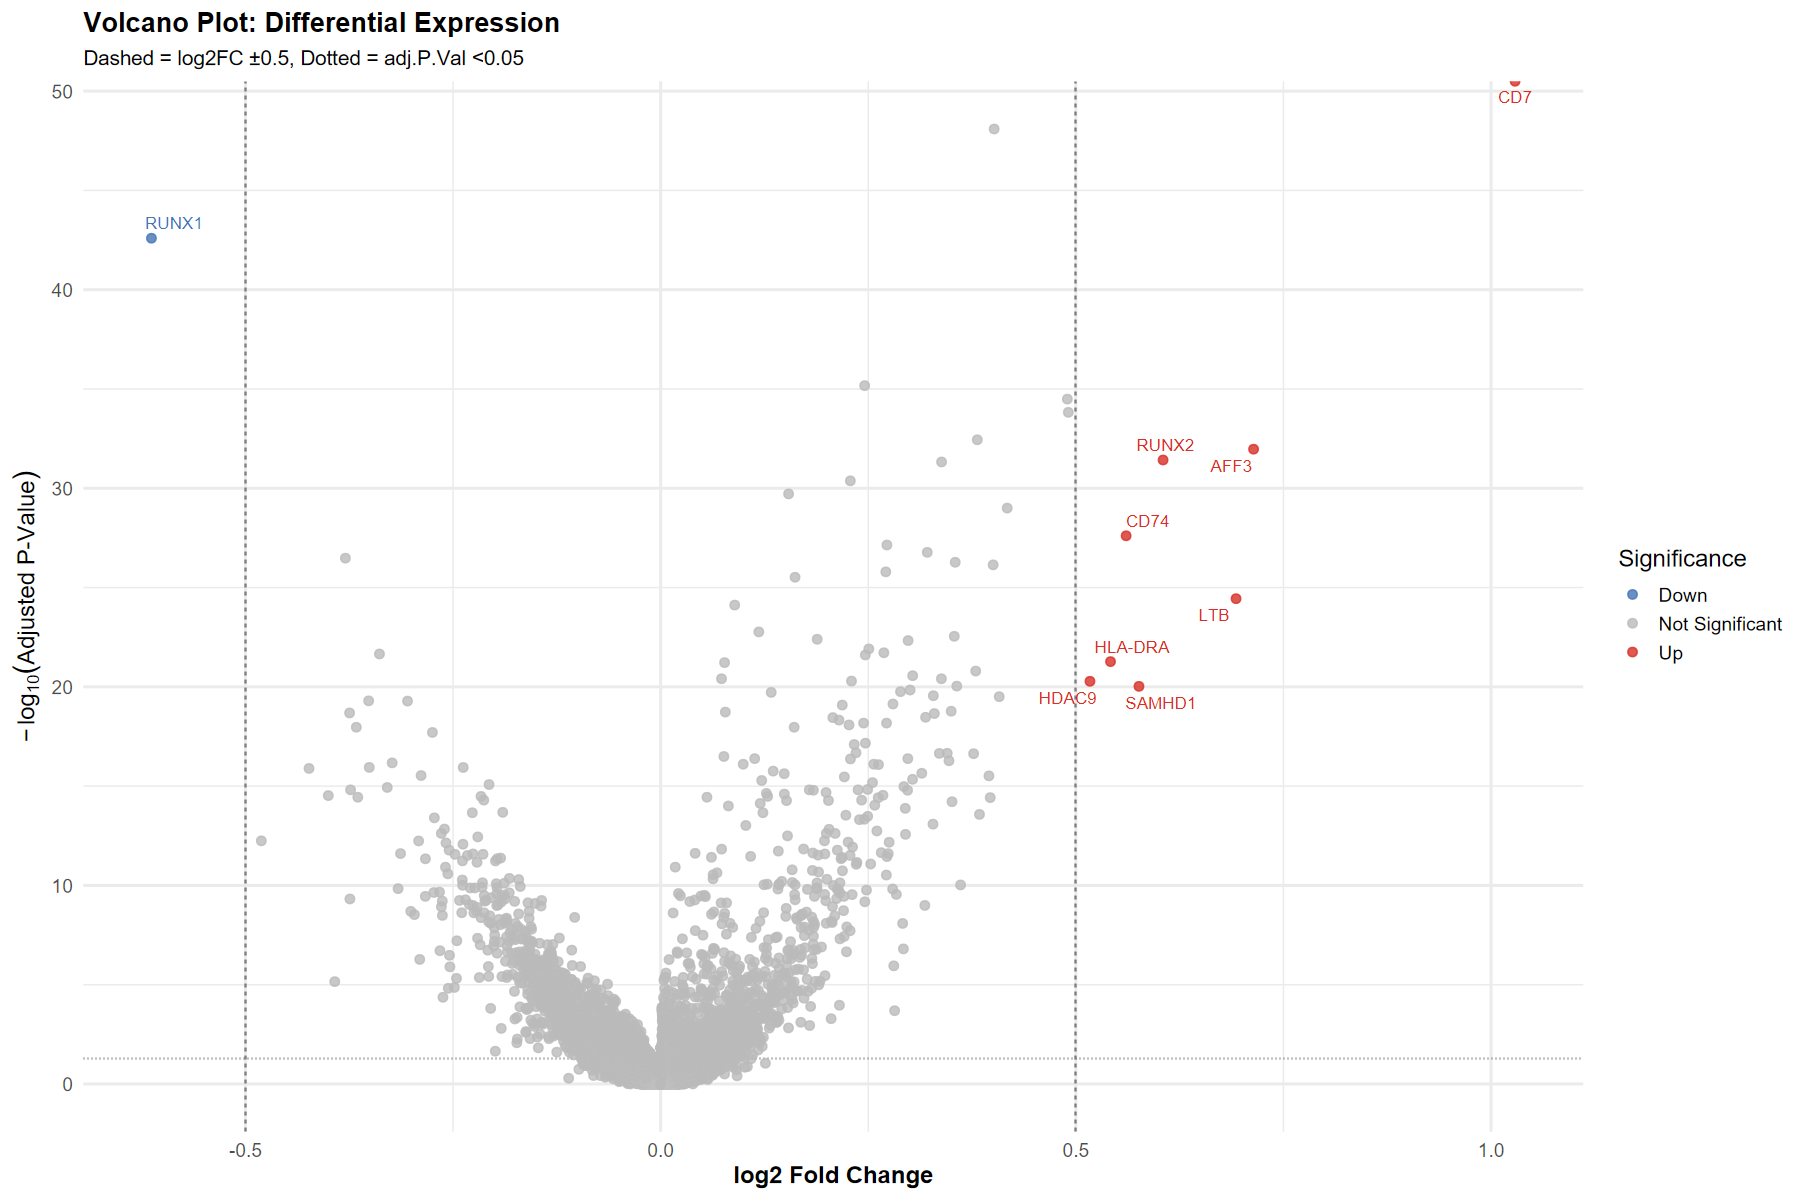

In [ ]:
draw_volcano(result)


Here's my interpretation of these results: 

- T-lineage markers and functions (CD7, HLA-DRA, CD74) are upregulated in CD7⁺ cells.

- RUNX1 and RUNX2, key transcription factors with known hematopoietic roles, are more abundant in CD7⁺, suggesting transcriptional priming.

- AFF3 and HDAC9 point to epigenetic and transcriptional activation pathways being engaged.

- SAMHD1 and LTB suggest additional regulation of cell fate and immune signaling.

> Overall, this suggests that CD45RA⁺CD7⁺ cells exhibit transcriptional features consistent with early lymphoid/T-lineage priming relative to CD45RA⁺CD7⁻ cells. However, the absence of definitive T-lineage transcription factors (e.g., GATA3, TCF7, BCL11B) indicates that commitment is not yet fully established.

### RQ3:  Do CD45RA⁺7+ Cells Show Higher T-Lineage Gene Module Scores Than Just CD7+ Cells?  Does the Acquisition of CLEC12A Affect This?

In this section, I will be evaluating the performance of Different populations against generating T-cell scores. We already answered the question "Is CD7 statistically correlated with T-Cell Program Scores -> It's not". This analysis was conducted over all HSCs, as typically in literature, people use CD7+ as a standalone marker, or in conjunction with CD5+ to indicate T-lineage bias. 

Now, I'm (hoping) to improve the score (and achieve statistical correlation) by subsetting on the CD45RA+ population, and comparing if having DP CD45RA+7+ cells improves the score compared to the Aim 2 results (Just CD7+ cells), and if the acquisition of CLEC changes this behaviour.  

In Essence, we are going to complete this analysis in two parts: 

1. CD45RA⁺CD7⁺ vs. CD7⁺ (i.e. does CD45RA status enhance T-lineage priming?)

2. The influence of CLEC12A expression on any of the above patterns.

Let's begin by defining the scoring program: 

In [ ]:
# Defining T-Cell Program Genes
# --- 1. Define the T-cell program gene list ---
tcell_genes <- c(
  "RAG2", "NOTCH1", "CD3D", "CD3E", "CD3G",
  "TCF7", "GATA3", "BCL11B", "RAG1", "DTX1",
  "IL7R", "PTCRA", "LEF1", "SPI1", "RUNX1",
  "BCL11A", "IKZF1", "ZBTB16"
)

# --- 2. Ensure genes are present in the SCE object ---
tcell_genes_present <- intersect(tcell_genes, rownames(merge2_light))

# Optional: print genes that were missing
missing_genes <- setdiff(tcell_genes, rownames(merge2_light))
cat("Missing genes:", paste(missing_genes, collapse = ", "), "\n")

# --- 3. Score each cell using average log-normalized expression ---
# (assuming logcounts(merge2) contains log-normalized RNA expression)
tcell_scores <- colMeans(logcounts(merge2_light)[tcell_genes_present, , drop = FALSE]) # nolint

# --- 4. Store the T-cell score in the metadata ---
colData(merge2_light)$Tcell_score <- tcell_scores

# There's some lack of specifictity in the program above, so I'm going to make an even stricter one below:

# Defining T-Cell Program Genes
# --- 1. Define the T-cell program gene list ---
tcell_tough_genes <- c(
  "RAG2", "NOTCH1", "CD3D", "CD3G",
  "TCF7", "GATA3", "BCL11B", "RAG1", "DTX1",
  "IL7R", "PTCRA", "LEF1", "SPI1", "RUNX1",
  "BCL11A", "IKZF1", "ZBTB16"
)


# --- 2. Ensure genes are present in the SCE object ---
tcell_genes_present <- intersect(tcell_tough_genes, rownames(merge2_light))

# Optional: print genes that were missing
missing_genes <- setdiff(tcell_tough_genes, rownames(merge2_light))
cat("Missing genes:", paste(missing_genes, collapse = ", "), "\n")

# --- 3. Score each cell using average log-normalized expression ---
# (assuming logcounts(merge2) contains log-normalized RNA expression)
tcell_scores <- colMeans(logcounts(merge2_light)[tcell_genes_present, , drop = FALSE]) # nolint

# --- 4. Store the T-cell score in the metadata ---
colData(merge2_light)$Tcell_Tough_score <- tcell_scores


Missing genes:  
Missing genes:  


Now, let's begin with Part 1: 

Missing genes:  


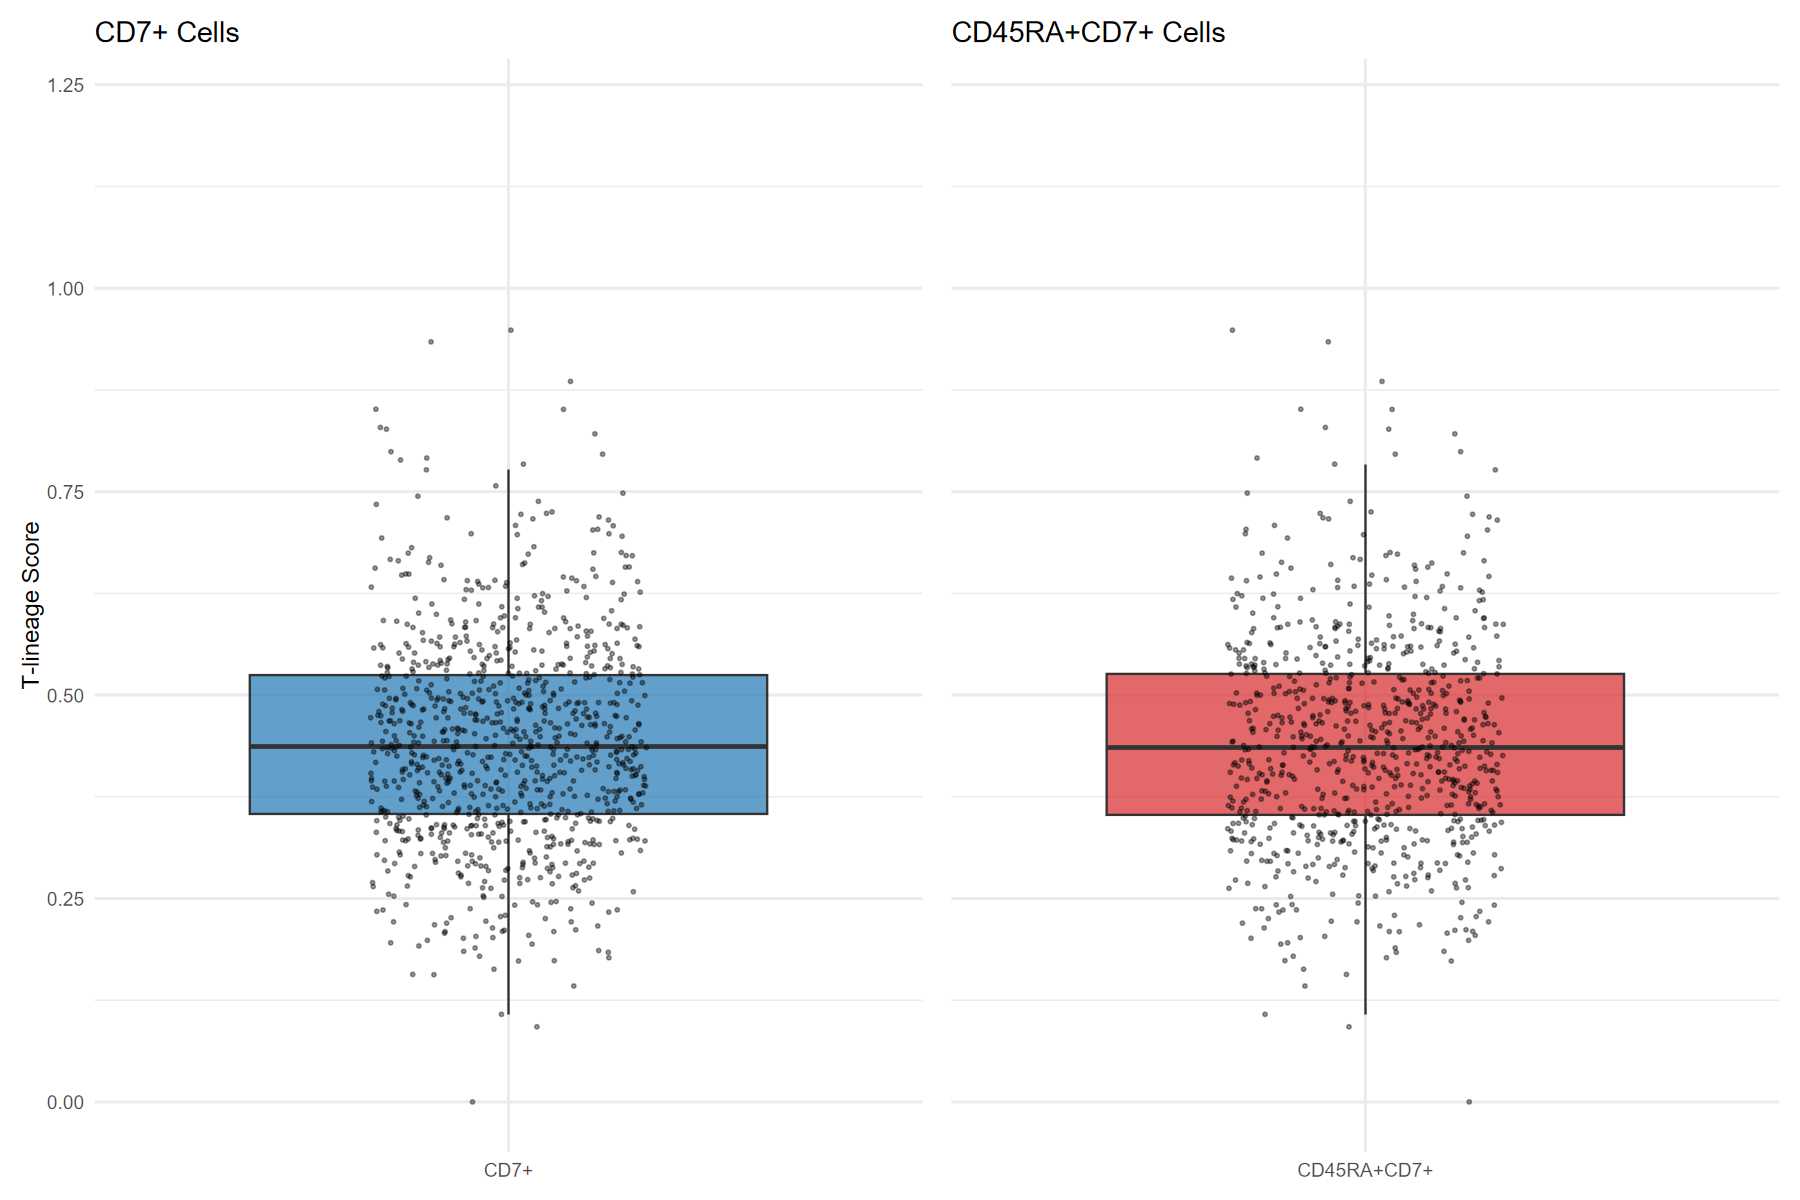

In [33]:
# 1. Define your T-lineage program gene set
tcell_genes <- c(
  "RAG2", "NOTCH1", "CD3D", "CD3E", "CD3G", "TCF7", "GATA3", "BCL11B",
  "RAG1", "DTX1", "IL7R", "PTCRA", "LEF1", "SPI1", "RUNX1",
  "BCL11A", "IKZF1", "ZBTB16"
)

# 2. Filter to genes present in the SCE object
tcell_genes_present <- intersect(tcell_genes, rownames(merge2_light))

# Optional: print missing genes
missing_genes <- setdiff(tcell_genes, rownames(merge2_light))
cat("Missing genes:", paste(missing_genes, collapse = ", "), "\n")

# 3. Score each cell by average expression of T-cell genes
tcell_scores <- colMeans(logcounts(merge2_light)[tcell_genes_present, , drop = FALSE])

# 4. Store scores in metadata
colData(merge2_light)$Tcell_score <- tcell_scores

# Get the metadata
meta_df <- as.data.frame(colData(merge2_light)) %>%
  mutate(cell = colnames(merge2_light))

# 1. Subset: CD7+ cells (all)
cd7_pos_df <- meta_df %>%
  filter(CD7_adtStat == "CD7+")

# 2. Subset: CD45RA+CD7+ cells only
cd7_ra_pos_df <- meta_df %>%
  filter(CD7_adtStat == "CD7+", CD45RA_stat == "CD45RA+")

# 3. Determine shared y-axis scale range
y_min <- min(meta_df$Tcell_score, na.rm = TRUE)
y_max <- max(meta_df$Tcell_score, na.rm = TRUE)

# 4. Make the two plots
p1 <- ggplot(cd7_pos_df, aes(x = "CD7+", y = Tcell_score)) +
  geom_boxplot(fill = "#1f77b4", alpha = 0.7, outlier.shape = NA) +
  geom_jitter(width = 0.2, size = 0.6, alpha = 0.4) +
  ylim(y_min, y_max) +
  labs(
    title = "CD7+ Cells",
    y = "T-lineage Score",
    x = NULL
  ) +
  theme_minimal(base_size = 14)

p2 <- ggplot(cd7_ra_pos_df, aes(x = "CD45RA+CD7+", y = Tcell_score)) +
  geom_boxplot(fill = "#d62728", alpha = 0.7, outlier.shape = NA) +
  geom_jitter(width = 0.2, size = 0.6, alpha = 0.4) +
  ylim(y_min, y_max) +
  labs(
    title = "CD45RA+CD7+ Cells",
    y = NULL,
    x = NULL
  ) +
  theme_minimal(base_size = 14) +
  theme(axis.text.y = element_blank(), axis.ticks.y = element_blank())

# 5. Combine plots side-by-side
p1 + p2 + plot_layout(ncol = 2)


Big Oof. It looks like There isn't much difference here between the two populations. Let's do some statistical testing to see if there's a difference: 

In [38]:
# 1 - Let's look at a SLR to see if we can improve scores

cd7_model <- lm(Tcell_score ~ CD7_adt, data = meta_df) # baseline model
tidy(cd7_model)

cd7cd45ra_model <- lm(Tcell_score ~ CD7_adt + CD45RA_adt, data = meta_df) # model with CD45RA
tidy(cd7cd45ra_model)


term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),0.4387958724,0.001169412,375.227787,0.000000
CD7_adt,0.0006293015,0.000481905,1.305862,0.191624


term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),3.946758e-01,0.0031890687,123.7589521,0.000000e+00
CD7_adt,8.396653e-05,0.0004790292,0.1752848,8.608588e-01
CD45RA_adt,6.583985e-03,0.0004433590,14.8502351,1.875887e-49


Very surprising given the boxplots! 

**Interpreting Results From Model 1 (CD7 Only)**: 

There is not enough evidence to make the claim that CD7_adt expression is associated with T-cell score (p = 0.19). There is no statistically significant evidence that CD7_adt alone predicts T-lineage gene module scores.

**Interpreting Results from Model 2 (CD7 & CD455RA)**: 

Holding CD7 constant, there is statistically significant evidence (p < 0.001) that CD45RA⁺ expression is associated with an increase in T-lineage scores. The effect size is small but precise, suggesting CD45RA adds marginal predictive value to the model.

This suggests that while CD7⁺ alone is not predictive, adding CD45RA⁺ expression significantly improves the model’s ability to predict T-lineage priming.

**Takeaway**: 

> Based on the SLR model output, the addition of CD45RA_adt as a predictor significantly improves the model's fit to Tcell_score, as evidenced by a p-value < 0.001. This suggests that CD45RA⁺ is a statistically significant predictor of T-lineage program scores when controlling for CD7 expression.

This is indicating that CD45RA⁺CD7⁺ cells may indeed reflect stronger or more consistent T-lineage priming, even if the effect is subtle on raw distributions.


Great! Let's now look at how the acquisition of CLEC affects this dynamic!: 

In [ ]:
# Fit a model with interactions between CD7_adt, CD45RA_adt, and CLEC12A Group
interaction_df <- meta_df %>%
    filter(Group %in% c("Cneg", "Cpos")) # Filter to only Cneg and Cpos groups

interaction_model <- lm(Tcell_score ~ CD7_adt * Group + CD45RA_adt * Group, data = interaction_df)

# View model summary
tidy(interaction_model)


term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),0.3808898720,0.0038586702,98.710139,0.000000e+00
CD7_adt,0.0009765631,0.0006105230,1.599552,1.097271e-01
GroupCpos,0.0373864464,0.0077038466,4.852958,1.233210e-06
CD45RA_adt,0.0097120363,0.0005460187,17.787005,8.617545e-70
CD7_adt:GroupCpos,-0.0017328004,0.0010174216,-1.703129,8.857245e-02
GroupCpos:CD45RA_adt,-0.0075479172,0.0010388983,-7.265309,3.976460e-13


Here's what the coefficients mean: 

---

`(Intercept)`
There is enough statistical evidence to make the claim that the **mean T-cell score** for **Cneg cells** when both **CD7_adt and CD45RA_adt = 0** is approximately **0.381**, and this is statistically significant at p < 0.05.

`CD7_adt`
There is **not enough statistical evidence** to make the claim that CD7_adt is associated with T-cell score in Cneg cells (p = 0.110).

`GroupCpos`
There is enough statistical evidence to make the claim that **Cpos cells** have, on average, a **T-cell score 0.0374 higher** than Cneg cells when CD7_adt and CD45RA_adt are both 0 (p < 0.001).

`CD45RA_adt`
There is enough statistical evidence to make the claim that, among **Cneg cells**, for every 1 unit increase in **CD45RA_adt**, the mean **T-cell score increases by 0.0097**, which is statistically significant at p < 0.001.

`CD7_adt:GroupCpos` (Interaction)
There is **not enough statistical evidence** to make the claim that the effect of CD7_adt on T-cell score is different between **Cpos** and **Cneg** cells (p = 0.0886).

`GroupCpos:CD45RA_adt` (Interaction)
There is enough statistical evidence to make the claim that the effect of CD45RA_adt on T-cell score is different between Cpos and Cneg groups. Specifically, the **marginal effect of CD45RA_adt is reduced by 0.0075** in Cpos cells compared to Cneg (p < 0.001).

---

**Interpretation**
- CD45RA_adt is a **strong and significant predictor** of T-cell score in Cneg cells.
- GroupCpos cells overall have higher T-cell scores than Cneg cells when marker levels are held at 0.
- However, the strength of association between CD45RA_adt and T-cell score is **weaker** in Cpos cells.
- CD7_adt does **not appear to have a significant effect** on T-cell scores in either group.
- This supports the idea that **CD45RA**, not CD7, is more reliably associated with **T-lineage transcriptional activity** — particularly in Cneg cells.


**Alignment with Fangwu's Paper**
These results are consistent with the biological interpretation expected from Fangwu Wang's CLEC paper, where **CLEC12A⁺ (Cpos) cells are proposed to be myeloid-biased (especially neutrophil/monocyte)**, while **CLEC12A⁻ (Cneg) cells** are more lymphoid-permissive.

According to Fangwu: 

- CLEC12A⁺ cells are **monocyte/neutrophil-biased** and **lose lymphoid competence** early.
- CLEC12A⁻ cells retain **T-lineage priming potential**.
- CD45RA and CD7 are used as early T-cell–associated surface markers in the transition from HSC → T-lineage.

According to my results: 
1. **CD45RA_adt** was a **strong predictor** of higher T-cell scores in **Cneg** (CLEC12A⁻) cells. This aligns with FW, since Cneg is supposed to be more T-permissive. 
2. The **CD45RA_adt × GroupCpos interaction** was **significantly negative**, meaning the effect of CD45RA expression on T-cell scores is **reduced in Cpos (CLEC12A⁺) cells**, consistent with **a loss of lymphoid potential**.
3. **CD7_adt** was not a strong predictor — aligning with previous Aim 2 findings that **CD7 expression is not reliably correlated with transcriptional T-priming**.
4. **GroupCpos had a higher intercept**, but this is only meaningful at CD45RA = 0, which might not be biologically relevant — so it does **not contradict the overall directionality** of CLEC function.

---

**Conclusion**:
This model, and these results, fit very well with the known lineage trajectory:

- **CD45RA⁺ Cneg cells** show strong T-lineage transcriptional activity.
- **CD45RA⁺ Cpos cells** do **not** show the same benefit — the **CD45RA marker does not convey T-lineage meaning in Cpos cells**.

This supports the idea that **Cpos cells are “biased” into a non-lymphoid fate**, even when they express CD45RA.


### RQ4: What Are the Transcriptional Profiles and Phenotypes of CD45RA⁺CD7⁺ Subclusters With Elevated T-Lineage Scores (if any)? 

Ok, now that we have some statistical support indicating that CD45RA+7+ is better than just CD7+ as a standalone marker for T-cell scoring, I wonder if there will be clustering within this double positive population that have especially elevated scores? Then, we could conduct DGE analysis on that cluster, look at the highly expressed CD markers, and perhaps add that as a predictor to our linear model as well - hopefully further improving T-cell scoring. 

Let's begin by creating an SCE object with the relevant cells (that is, CD45RA+7+ DP cells). We will begin by subsetting our SCE object, clustering on T-sne, and then plotting an elbow plot to find the optimal number of clusters: 

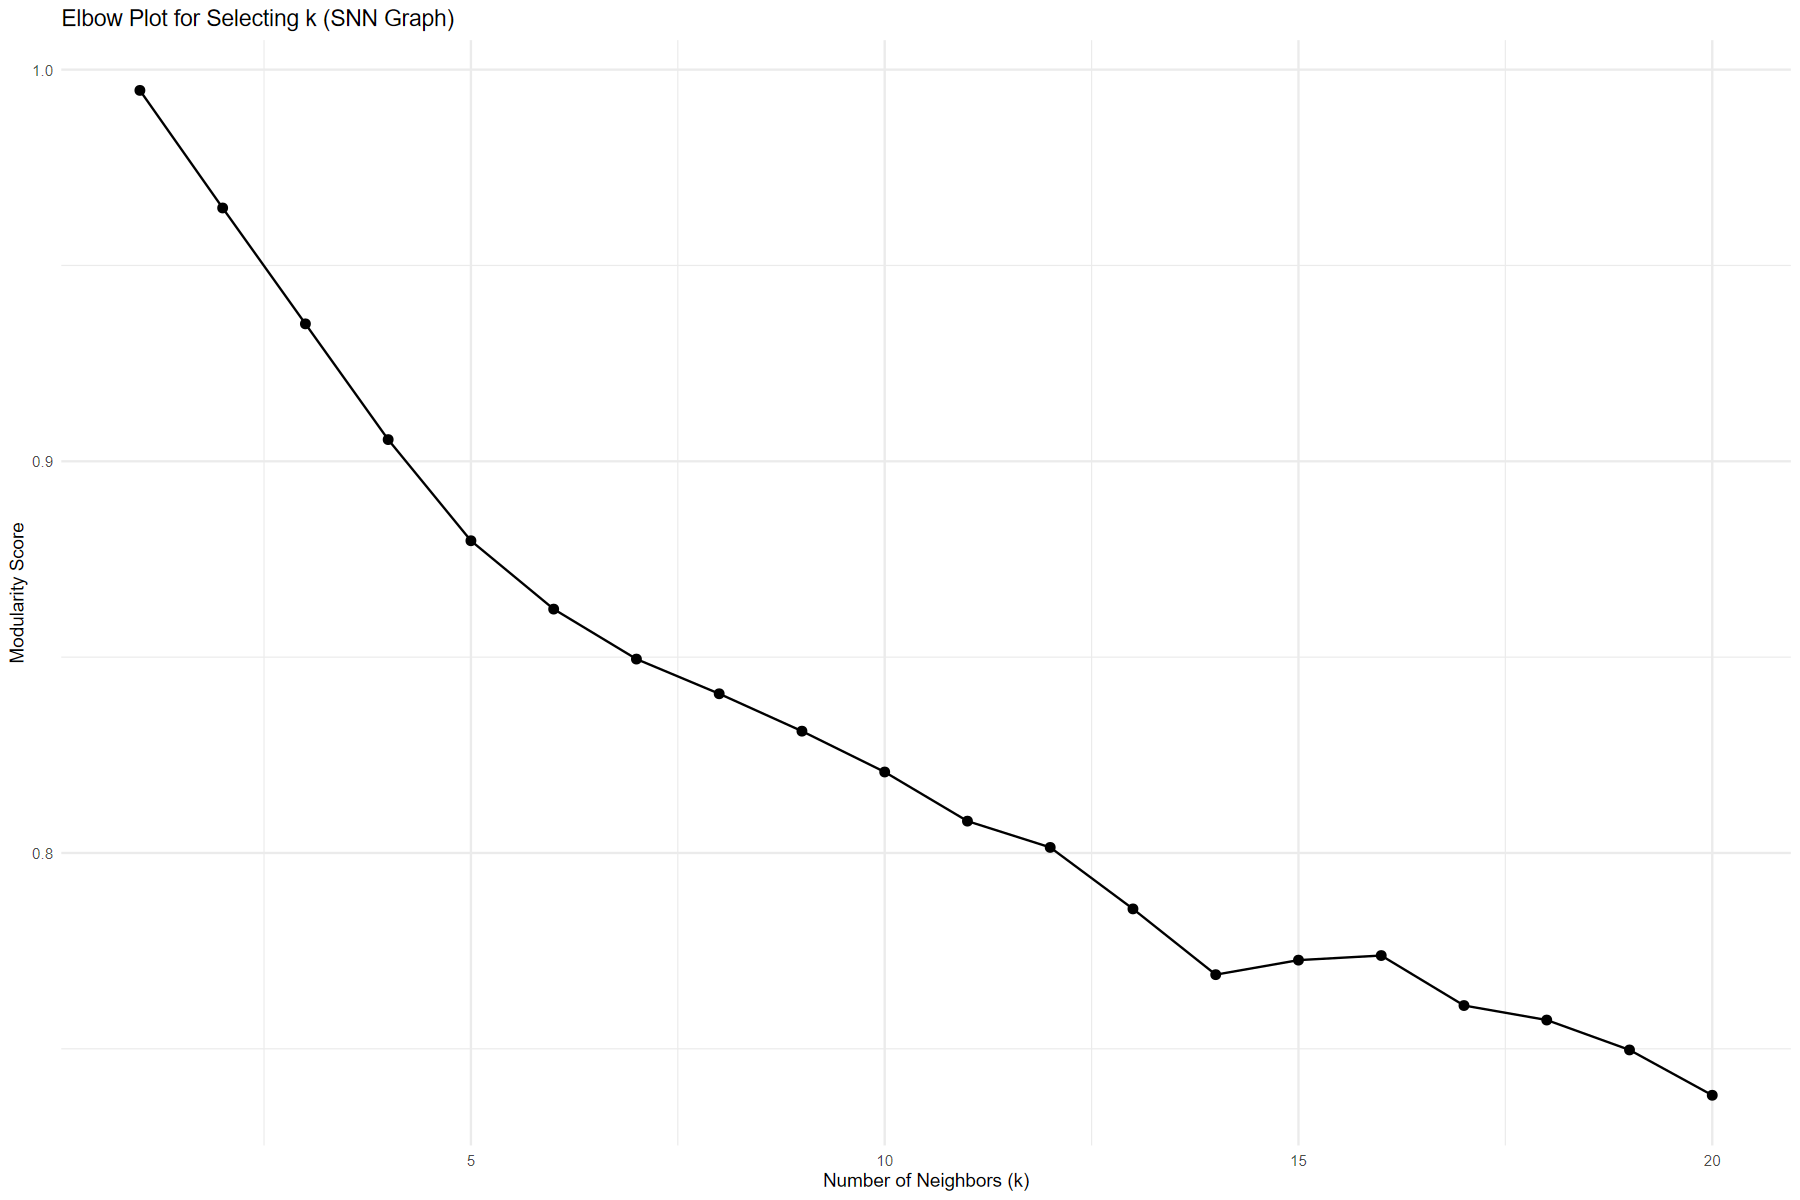

In [ ]:
# Subsetting DP cells

sce_dp <- merge2_light[
  ,
  colData(merge2_light)$CD45RA_stat == "CD45RA+" &
    colData(merge2_light)$CD7_adtStat == "CD7+"
]

# Score Each Cell with T-lineage Program
tcell_genes_present <- intersect(tcell_tough_genes, rownames(merge2_light))

dp_tcell_score <- colMeans(logcounts(sce_dp)[tcell_genes_present, , drop = FALSE])
colData(sce_dp)$Tcell_score <- dp_tcell_score


# Values of k to test
k_values <- seq(1, 20, by = 1)

# Placeholder for modularity scores
modularity_scores <- numeric(length(k_values))

# Loop through k and calculate modularity of the clusters
for (i in seq_along(k_values)) {
  k <- k_values[i]
  g <- buildSNNGraph(sce_dp, use.dimred = "TSNE", k = k)
  clust <- cluster_walktrap(g)
  modularity_scores[i] <- modularity(clust)
}


elbow_df <- tibble(k = k_values, Modularity = modularity_scores)

ggplot(elbow_df, aes(x = k, y = Modularity)) +
  geom_point(size = 2) +
  geom_line() +
  theme_minimal() +
  labs(
    title = "Elbow Plot for Selecting k (SNN Graph)",
    x = "Number of Neighbors (k)",
    y = "Modularity Score"
  )


I would say the elbow here is at 14, so let's go with that. Especially since I am trying to find a likely elusive population. 

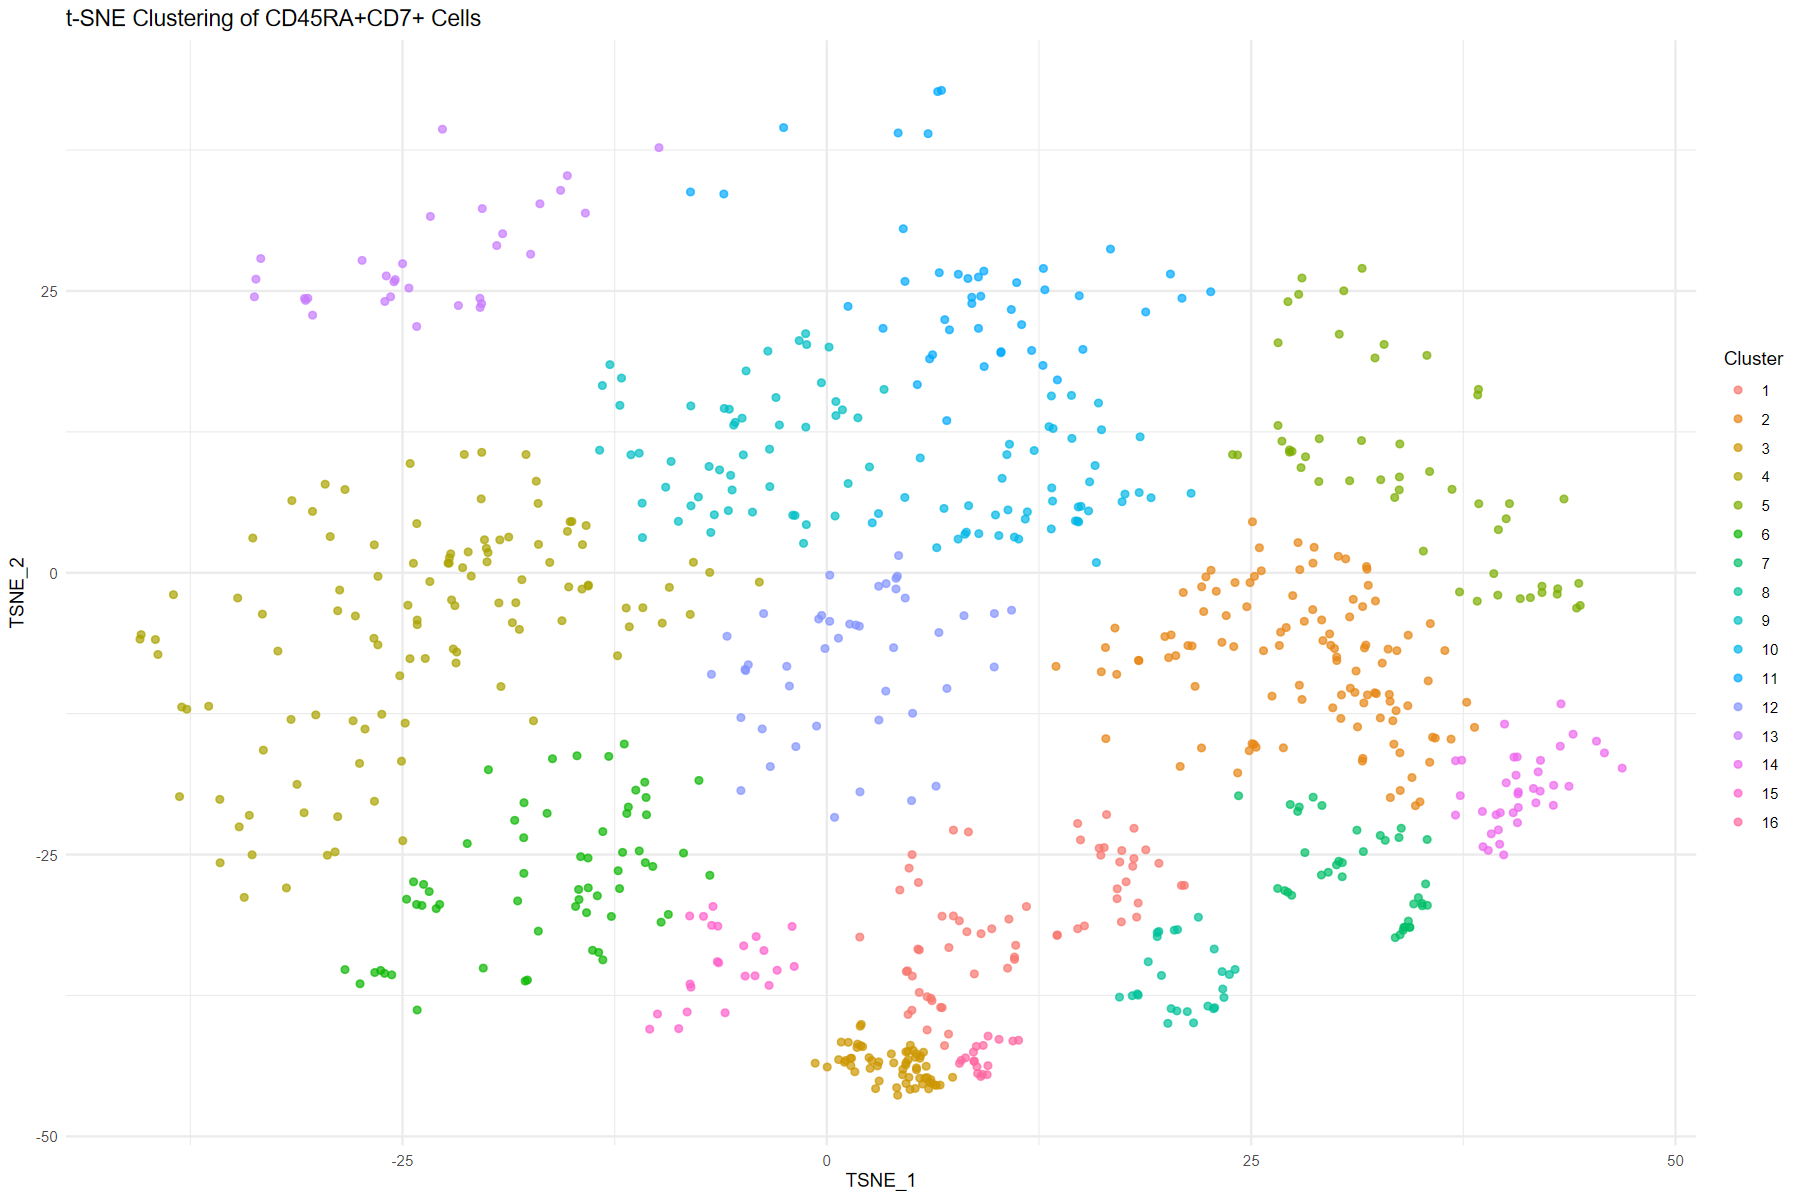

In [ ]:
# Begin Clustering on DP cells

g_tsne <- buildSNNGraph(sce_dp, use.dimred = "TSNE", k = 14)

# Run community detection (e.g., Walktrap)
tsne_clusters <- igraph::cluster_walktrap(g_tsne)$membership

# Add to colData
colLabels(sce_dp) <- factor(tsne_clusters)


# Extract t-SNE coords
tsne_coords <- reducedDim(sce_dp, "TSNE")

# Build plotting dataframe
tsne_df <- data.frame(
  TSNE_1 = tsne_coords[, 1],
  TSNE_2 = tsne_coords[, 2],
  Cluster = as.factor(colLabels(sce_dp))
)

# Plot
ggplot(tsne_df, aes(x = TSNE_1, y = TSNE_2, color = Cluster)) +
  geom_point(alpha = 0.7, size = 1.5) +
  theme_minimal() +
  labs(
    title = "t-SNE Clustering of CD45RA+CD7+ Cells",
    color = "Cluster"
  )


Amazing! Let's now look at the T-lineage score of each cluster. I pray we find something that's elevated within this population: 

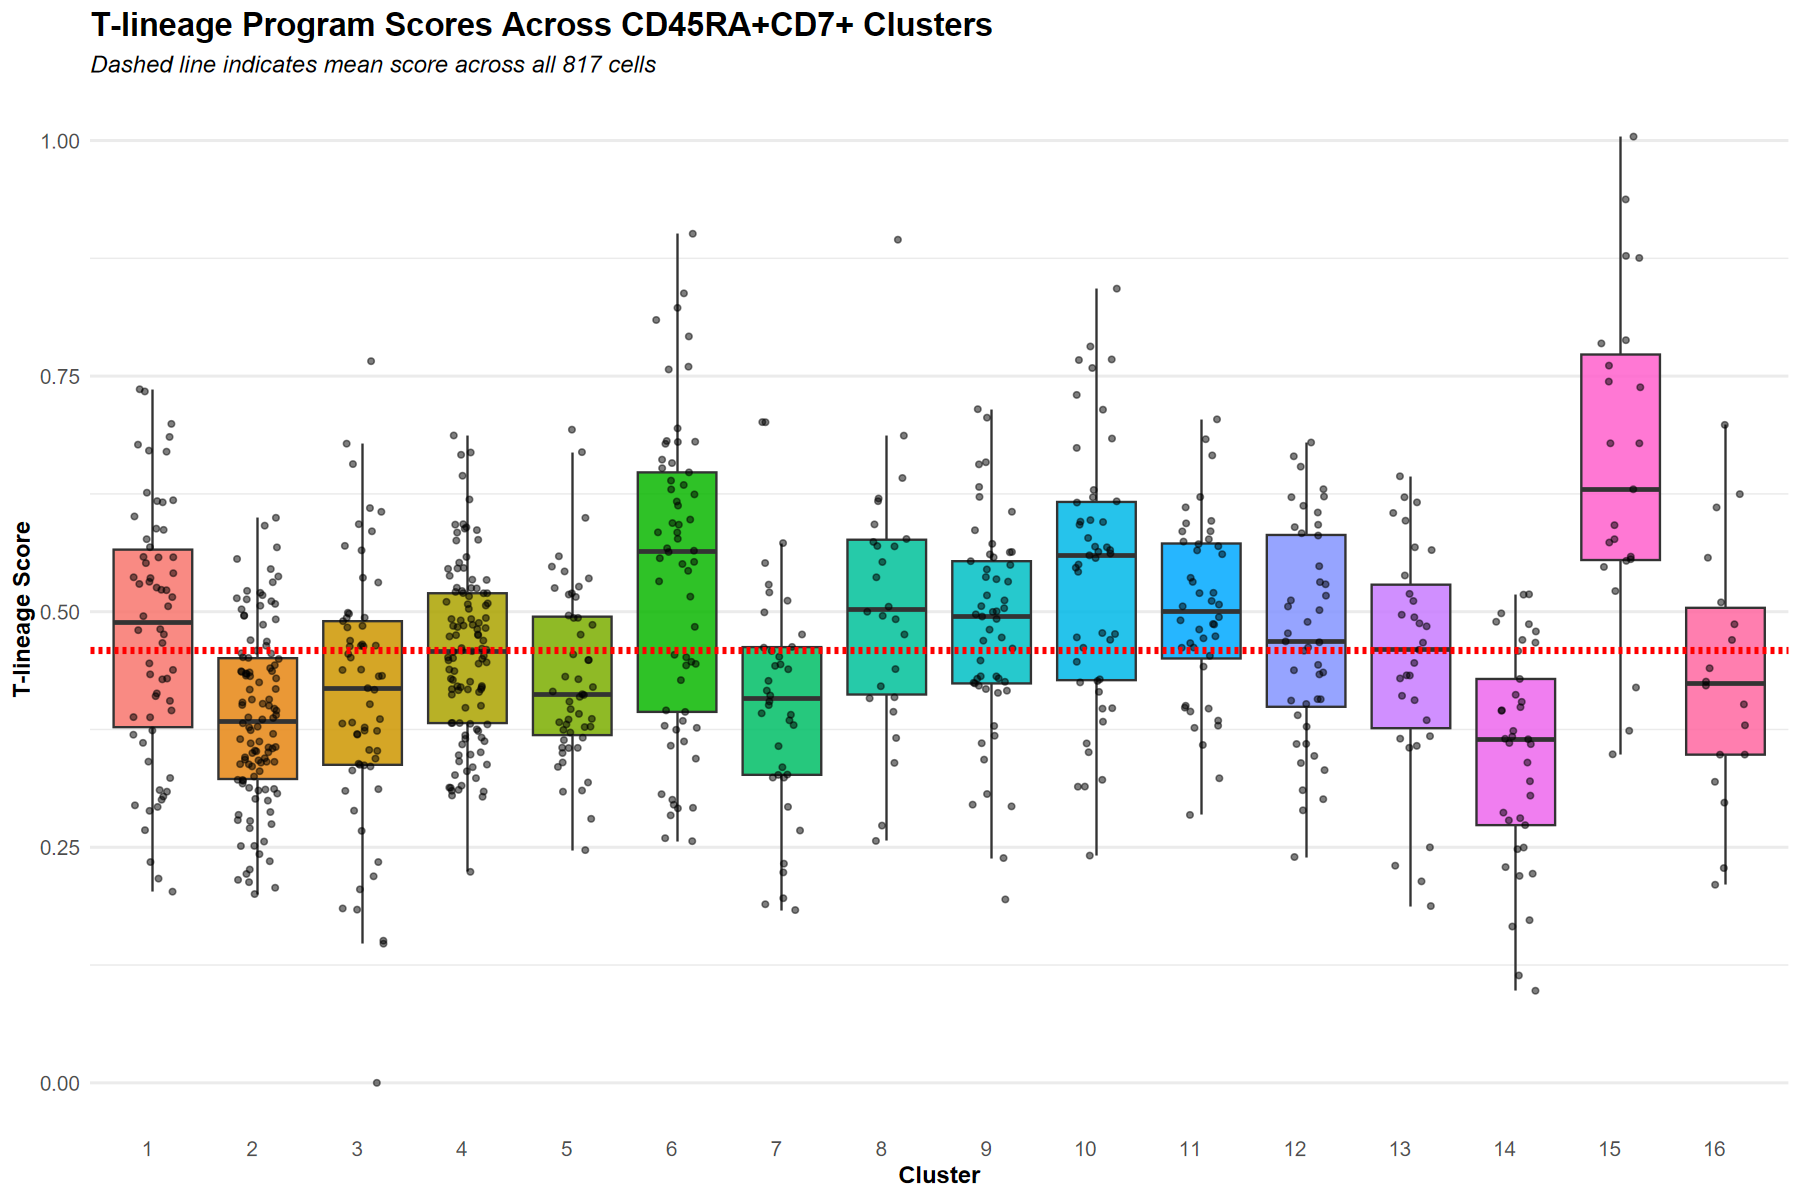

In [ ]:
# Create plotting dataframe
boxplot_df <- data.frame(
  Cluster = colLabels(sce_dp),
  TlineageScore = colData(sce_dp)$Tcell_score
)

# Compute global mean T-lineage score
mean_score <- mean(boxplot_df$TlineageScore, na.rm = TRUE)

# Plot
ggplot(boxplot_df, aes(x = Cluster, y = TlineageScore, fill = Cluster)) +
  geom_boxplot(outlier.shape = NA, alpha = 0.85) +
  geom_jitter(width = 0.2, size = 1.2, alpha = 0.5, color = "black") +
  geom_hline(yintercept = mean_score, linetype = "dashed", color = "red", linewidth = 1.5) +
  scale_fill_manual(values = scales::hue_pal()(length(unique(boxplot_df$Cluster)))) +
  labs(
    title = "T-lineage Program Scores Across CD45RA+CD7+ Clusters",
    subtitle = paste("Dashed line indicates mean score across all", nrow(boxplot_df), "cells"),
    x = "Cluster",
    y = "T-lineage Score"
  ) +
  theme_minimal(base_size = 14) +
  theme(
    axis.text.x = element_text(hjust = 1),
    legend.position = "none",
    panel.grid.major.x = element_blank(),
    title = element_text(size = 16, face = "bold"),
    plot.subtitle = element_text(size = 14, face = "italic"),
    axis.title = element_text(size = 14),
    axis.text = element_text(size = 12)
  )


This looks very promising! Let's do a statistical test comparing the T-lineage score of each cluster against the population mean: 

In [ ]:
# Step 1: Compute overall mean T-lineage score
overall_mean <- mean(boxplot_df$TlineageScore, na.rm = TRUE)

# Step 2: Apply a one-sample t-test for each cluster vs. the overall mean
cluster_tests <- boxplot_df %>%
  group_by(Cluster) %>%
  summarise(
    n = n(),
    mean_score = mean(TlineageScore),
    t_test = list(t.test(TlineageScore, mu = overall_mean, alternative = "greater"))
  ) %>%
  mutate(
    p_value = sapply(t_test, function(x) x$p.value),
    significance = case_when(
      p_value < 0.001 ~ "***",
      p_value < 0.01 ~ "*",
      p_value < 0.05 ~ "ns",
      TRUE ~ "ns"
    )
  ) %>%
  select(Cluster, n, mean_score, p_value, significance) %>%
  filter(significance != "ns") %>% # Filter out non-significant results
  arrange(desc(mean_score)) # Sort by p-value

# View results
(cluster_tests)


Cluster,n,mean_score,p_value,significance
<fct>,<int>,<dbl>,<dbl>,<chr>
15,23,0.6573798,8.275525e-06,***
10,47,0.5388405,1.470111e-04,***
6,61,0.5369192,1.818757e-04,***
11,44,0.5014299,2.298684e-03,*


Great! There is enough evidence to claim from a  One-Sided T.test result that clusters  6, 10, 11 (minor) and 15 have significantly higher T-cell scores! Amazing! Let's see what genes are differentially expressed in each of these clusters compared to the remaining DP population. 

I am particularly interested in CD genes, since I'm curious if I can find a more restricted T-lineage population within this DP population. 

Lets begin by conducting DGE here: 

In [ ]:
run_dge_for_cluster <- function(expr_matrix, cluster_labels, target_cluster) {
  stopifnot(length(cluster_labels) == ncol(expr_matrix))

  # Create binary group vector (target cluster vs rest)
  group_vector <- ifelse(cluster_labels == target_cluster, "Target", "Other")

  # Create design matrix
  group_factor <- factor(group_vector, levels = c("Other", "Target")) # "Other" is baseline
  design <- model.matrix(~group_factor)

  # Fit model
  fit <- lmFit(expr_matrix, design)
  fit <- eBayes(fit)

  # Get top DE genes (coef=2 because 'Target' is the second factor level)
  top_genes <- topTable(fit, coef = 2, number = Inf, sort.by = "logFC")

  # Get CD genes only (e.g., CD3, CD7, CD45, etc.)
  cd_genes <- top_genes[grep("^CD\\d+", top_genes$ID), ]

  return(list(
    top_genes = top_genes,
    top_cd_genes = cd_genes
  ))
}


Now, let's run all the DGE on all of our clustering: 

In [ ]:
# Make sure your sce_dp object and clusters are defined
cluster_vector <- colLabels(sce_dp)

# Run for cluster 6:
dge_cluster6 <- (run_dge_for_cluster(
    expr_matrix = logcounts(sce_dp),
    cluster_labels = cluster_vector,
    target_cluster = "6"
)
)


dge_cluster10 <- (run_dge_for_cluster(
    expr_matrix = logcounts(sce_dp),
    cluster_labels = cluster_vector,
    target_cluster = "10"
)
)

dge_cluster11 <- (run_dge_for_cluster(
    expr_matrix = logcounts(sce_dp),
    cluster_labels = cluster_vector,
    target_cluster = "11"
)
)

dge_cluster15 <- (run_dge_for_cluster(
    expr_matrix = logcounts(sce_dp),
    cluster_labels = cluster_vector,
    target_cluster = "15"
)
)


Warning message:
"Zero sample variances detected, have been offset away from zero"
Warning message:
"Zero sample variances detected, have been offset away from zero"
Warning message:
"Zero sample variances detected, have been offset away from zero"
Warning message:
"Zero sample variances detected, have been offset away from zero"


Finally, let's look at the results from our Clustering. We will go through each Cluster one by one, and generate volcano plots. Let's first write a function to automate the task:  

In [ ]:
draw_cluster_volcano <- function(result) {
  # --- Assume result$top_genes already exists ---
  df <- result

  # Define thresholds
  fc_thresh <- 0.5
  pval_thresh <- 0.05

  # Annotate significance
  df <- df %>%
    mutate(
      Significant = case_when(
        adj.P.Val < pval_thresh & logFC > fc_thresh ~ "Up",
        adj.P.Val < pval_thresh & logFC < -fc_thresh ~ "Down",
        TRUE ~ "Not Significant"
      )
    )

  # Get top 10 genes for labeling
  top_labels <- df %>%
    filter(Significant != "Not Significant") %>%
    arrange(adj.P.Val) %>%
    slice_head(n = 10)

  # Make volcano plot
  ggplot(df, aes(x = logFC, y = -log10(adj.P.Val), color = Significant)) +
    # Highlight thresholds
    geom_vline(xintercept = c(-fc_thresh, fc_thresh), linetype = "dashed", color = "gray50") +
    geom_hline(yintercept = -log10(pval_thresh), linetype = "dotted", color = "gray50") +

    # Points
    geom_point(alpha = 0.8, size = 2) +

    # Labels
    geom_text_repel(
      data = top_labels,
      aes(label = ID),
      size = 3.5,
      max.overlaps = Inf,
      box.padding = 0.3,
      segment.color = "gray40",
      show.legend = FALSE
    ) +

    # Aesthetics
    scale_color_manual(values = c("Up" = "#d73027", "Down" = "#4575b4", "Not Significant" = "#bababa")) +
    labs(
      title = "Volcano Plot: Differential Expression",
      subtitle = paste0("Dashed = log2FC ±", fc_thresh, ", Dotted = adj.P.Val <", pval_thresh),
      x = "log2 Fold Change",
      y = expression(-log[10]("Adjusted P-Value")),
      color = "Significance"
    ) +
    theme_minimal(base_size = 14) +
    theme(
      plot.title = element_text(face = "bold", size = 16),
      plot.subtitle = element_text(size = 12),
      axis.title = element_text(face = "bold"),
      legend.position = "right"
    )
}


Now, let's begin with Cluster 15

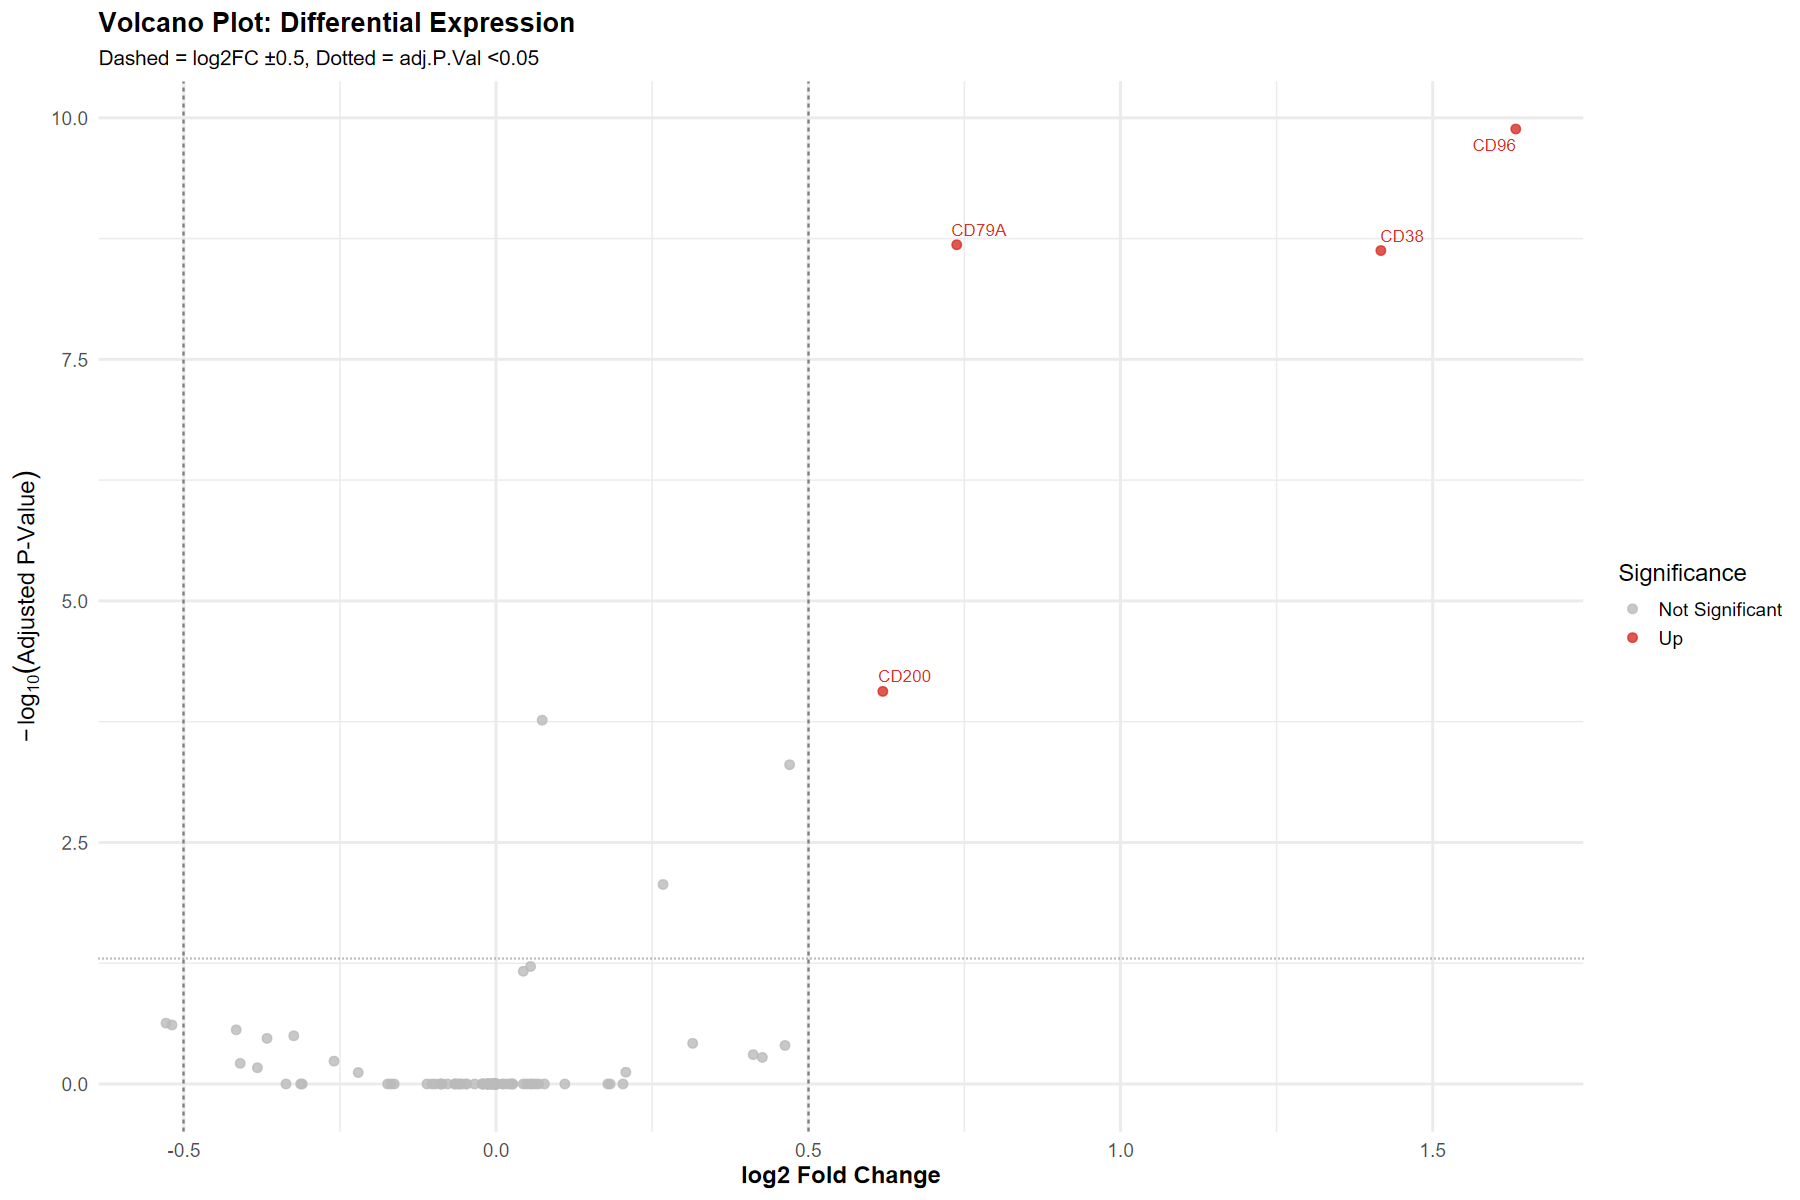

In [ ]:
draw_cluster_volcano(dge_cluster15$top_cd_genes)


Here's what these upregulated markerrs do: 
**2. CD Marker Expression (from Volcano Plot):**
Cluster 16 upregulates several key surface markers:

| Marker | Function | Interpretation |
|--------|----------|----------------|
| **CD96** | Adhesion & immune synapse formation in NK and T cells | Suggests activation or priming state of cytotoxic lymphocytes - CD8T, NK |
| **CD38** | Enzyme with roles in calcium signaling, marker of activation in T cells | Consistent with early CD4 CD8 or B-cell activation  |
| **CD200** | Transmembrane protein related to the B7 family of costimulatory receptors involved in T-cell signaling and likely plays a role in physiologic immune tolerance. | Thymocytes, B cells, Activated B/T, DCs |
| **CD79A** | B-cell receptor complex component | This is surprising — I don't know what this means |

 **Interpretation:**

Cluster 16 may represent a **rare but transcriptionally distinct T-cell-primed subpopulation** within the DP (CD45RA⁺CD7⁺) compartment — likely reflecting **activated, early-effector, or lineage-skewed progenitors**. The co-expression of CD96 and CD38 strengthens the idea that these cells are **immune effector precursors**, potentially biased toward **cytotoxic T cells** or **NK-like profiles**.  

The expression of **CD200** adds an interesting layer — possibly pointing to a **regulatory mechanism** buffering activation.

The presence of **CD79A**, while unexpected, does not negate the T-lineage bias. This might reflect either:
- **Lineage priming noise**, as seen in early hematopoiesis;
- Or shared developmental programs in early lymphoid cells.